<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/zadnja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import random

In [33]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **NESTO**

In [34]:
imgs_dir='/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_comb/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)
all_dirs.sort()

In [35]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def shuffle_split(all_dirs, val_pct=0.15, seed=99):
    seed_everything(seed)
    n_val = int(len(all_dirs) * val_pct)
    idx = np.random.permutation(len(all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    return all_dirs[n_val:], all_dirs[:n_val]

In [36]:
seed_everything(1)
train_dirs, valid_dirs = shuffle_split(all_dirs)
print(len(valid_dirs), len(train_dirs))

55 314


In [37]:
class BratsDataset (Dataset):
    def __init__ (self, img_dirs, modality_types, transform = None):
        self.img_dirs = img_dirs
        self.transform = transform
        self.modality_types = modality_types

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        mask = np.array(Image.open(f'{imgs_path}/{patient_id}_SEG_combined.jpg'))
        mask = (mask / 255 * 4).round()
        mask = self.preprocess_mask_labels(mask)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

         # Select only the first channel from the mask
        mask = mask[..., 0]
        return image.astype(float), mask.astype(float)

    ## Spajanje slika s id-om pacijenta
    def concat_imgs(self, path: str):
      patient_id = os.path.basename(path)
      types = []
      for modality_type in modality_types:
          img = np.array(Image.open(f'{path}/{patient_id}_{modality_type}_combined.jpg'))
          img = self.normalize(img)
          types.append(img)
      #return np.array(types)
      return np.array(types)[..., 0]

    ## Ova metoda pretvara izvornu masku segmentacije u one-hot kodiranu masku s četiri kanala koji predstavljaju različite regije tumora
    ## Cijeli tumor - WT, Tumorska jezgra - TC, Povećanje tumora - ET, Pozadina - BG
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        return mask

    ## Normalizacija ulaznih podataka
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min
        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['FLAIR', 'T1', 'T1CE', 'T2']

In [38]:
# Training transformations
trn_tfms = A.Compose([
    A.Resize(height=240, width=240),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
    ToTensorV2(),
])

# Validation transformations
val_tfms = A.Compose([
    A.Resize(height=240, width=240),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
    ToTensorV2(),
])

In [39]:
batch_size = 8

#Datasets
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)

#DataLoaders
#train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
#valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)

print(len(valid_dl ), len(train_dl))

7 40


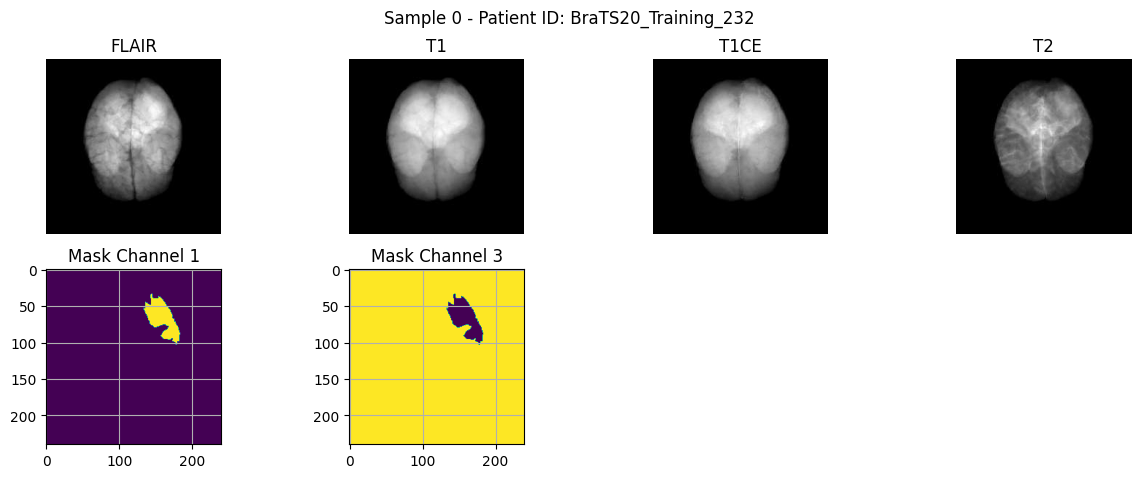

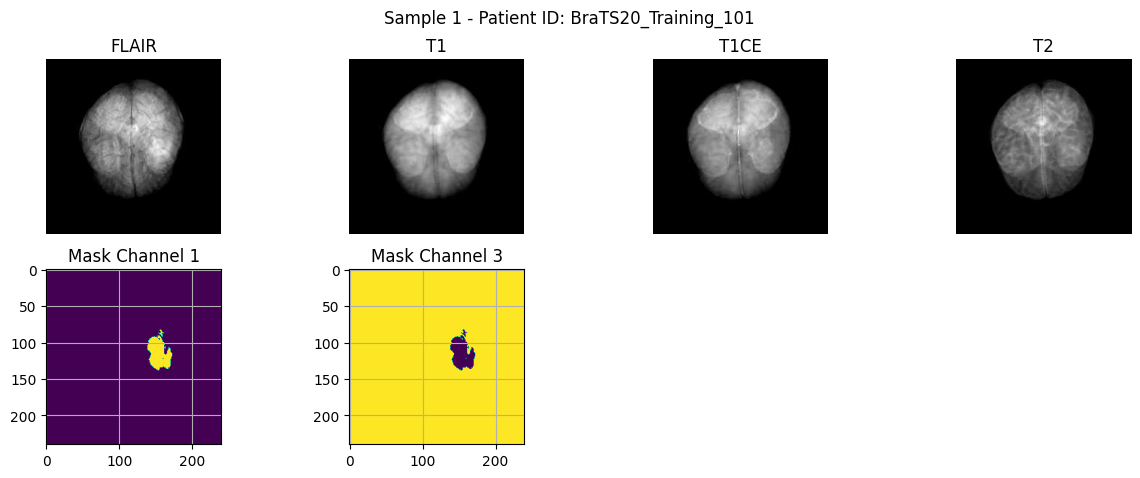

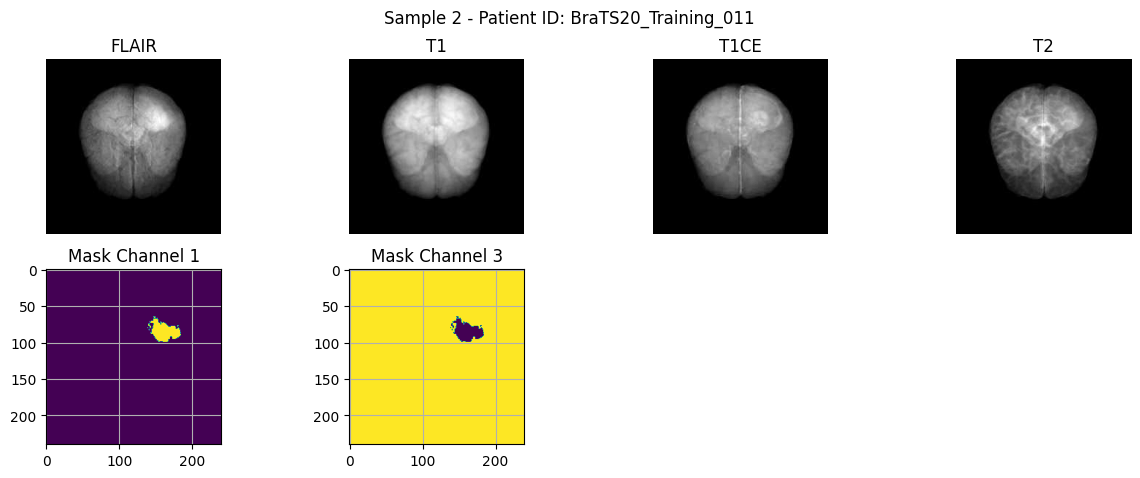

In [40]:
def visualize_samples(dataset, modality_types, num_samples):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Extract patient ID
        patient_id = os.path.basename(dataset.img_dirs[i])

        # Create a single figure with two rows
        plt.figure(figsize=(15, 5))

        # Visualize the MRI modalities in the first row
        for j in range(len(modality_types)):
            plt.subplot(2, len(modality_types), j + 1)
            plt.imshow(image[j], cmap='gray')
            plt.axis('off')
            plt.title(f"{modality_types[j]}")

        # Visualize channels 1 and 3 of the segmentation mask side by side in the second row
        plt.subplot(2, len(modality_types), len(modality_types) + 1)
        plt.imshow(mask[1], cmap='viridis')
        plt.grid()
        plt.title("Mask Channel 1")

        plt.subplot(2, len(modality_types), len(modality_types) + 2)
        plt.imshow(mask[3], cmap='viridis')
        plt.grid()
        plt.title("Mask Channel 3")

        plt.suptitle(f"Sample {i} - Patient ID: {patient_id}")
        plt.show()


visualize_samples(train_ds, modality_types, num_samples=3)

In [41]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down5 = Down(1024,2048)

        self.up0 = Up(2048,1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up0(x6,x5)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [42]:
## Računa Dice koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti (probabilities) i stvarnih oznaka (truth)
## Dice koeficijent mjeri sličnost između predviđenih i stvarnih područja
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

## Računa Jaccard koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti i stvarnih oznaka
## Jaccard koeficijent mjeri sličnost između predviđenih i stvarnih područja
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

In [43]:
## Klasa koja služi za praćenje i ažuriranje Dice i Jaccard koeficijenata tijekom evaluacije modela
class Meter:
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

## Klasa koja implementira gubitak temeljen na Dice koeficijentu
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1 - dice

## Klasa koja kombinira gubitak binarne unakrsne entropije (BCE) i gubitak temeljen na Dice koeficijentu
class BCEDiceLoss(nn.Module):
    def __init__(self, alpha, beta):
        super(BCEDiceLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.beta = beta
        self.dice = DiceLoss()

    def forward(self, input, target):
        return self.alpha * self.bce(input, target) + self.beta * self.dice(input, target)

In [44]:
## Pomoćne funkcije za test
## Računaju Dice i Jaccard koeficijente za svaku klasu u višeklasnoj segmentaciji
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

In [45]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9,0.999))

        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : val_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        for itr, (images, targets) in enumerate(tqdm(dataloader, desc=f"{phase} epoch {epoch + 1}/{self.num_epochs}")):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        print(f"Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        return epoch_loss

    ## Pokretanje treniranja kroz sve epohe
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['pink', 'violet']
        labels = [
            f"Train Loss: {self.losses['train'][-1]:.4f} \nValidation Loss: {self.losses['val'][-1]:.4f}",
            f"Train Dice: {self.dice_scores['train'][-1]:.4f} \nValidation Dice: {self.dice_scores['val'][-1]:.4f}",
            f"Train Jaccard: {self.jaccard_scores['train'][-1]:.4f} \nValidation Jaccard: {self.jaccard_scores['val'][-1]:.4f}"
        ]

        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[1], label="Training")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    ## Učitava unaprijed trenirani model iz pohranjenih težina
    def load_predtrain_model(self, state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")

    ## Spremanje težine modela i rezultate treniranja
    def _save_train_history(self):
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

In [46]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
#model = UNet(n_channels=4, n_classes=4, bilinear=True).to(device).float()
model = UNet(n_channels=4, n_classes=4).to(device)


In [47]:
trainer = Trainer(net = model,
                  train_dl = train_dl,
                  val_dl = valid_dl,
                  criterion = BCEDiceLoss(0.5,0.5),
                  #lr = 5e-4,
                  #lr = 1e-5,
                  lr = 0.0001,
                  accumulation_steps = batch_size,
                  batch_size = batch_size,
                  num_epochs = 60,
                 )

device: cuda


train epoch 1/60: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


Loss: 0.5595 | Dice: 0.8193 | IoU: 0.7130


val epoch 1/60: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Loss: 0.5478 | Dice: 0.8679 | IoU: 0.7670


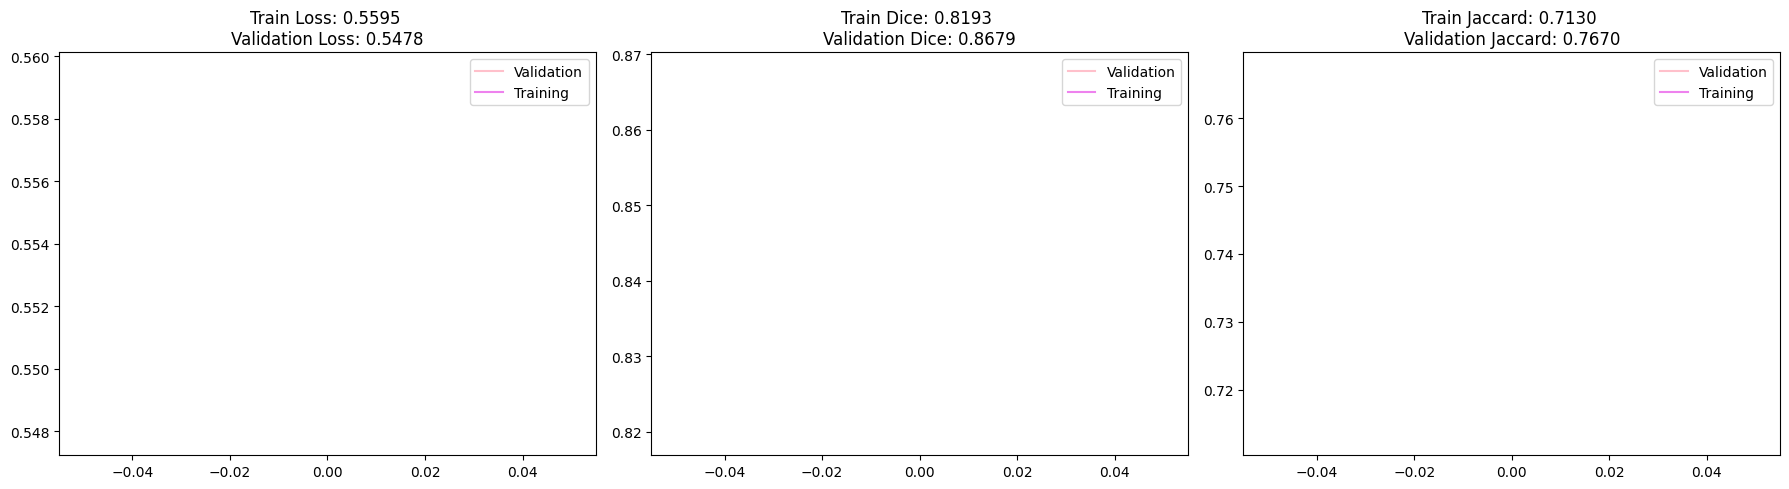

train epoch 2/60: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.4985 | Dice: 0.9736 | IoU: 0.9489


val epoch 2/60: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Loss: 0.4854 | Dice: 0.9805 | IoU: 0.9620


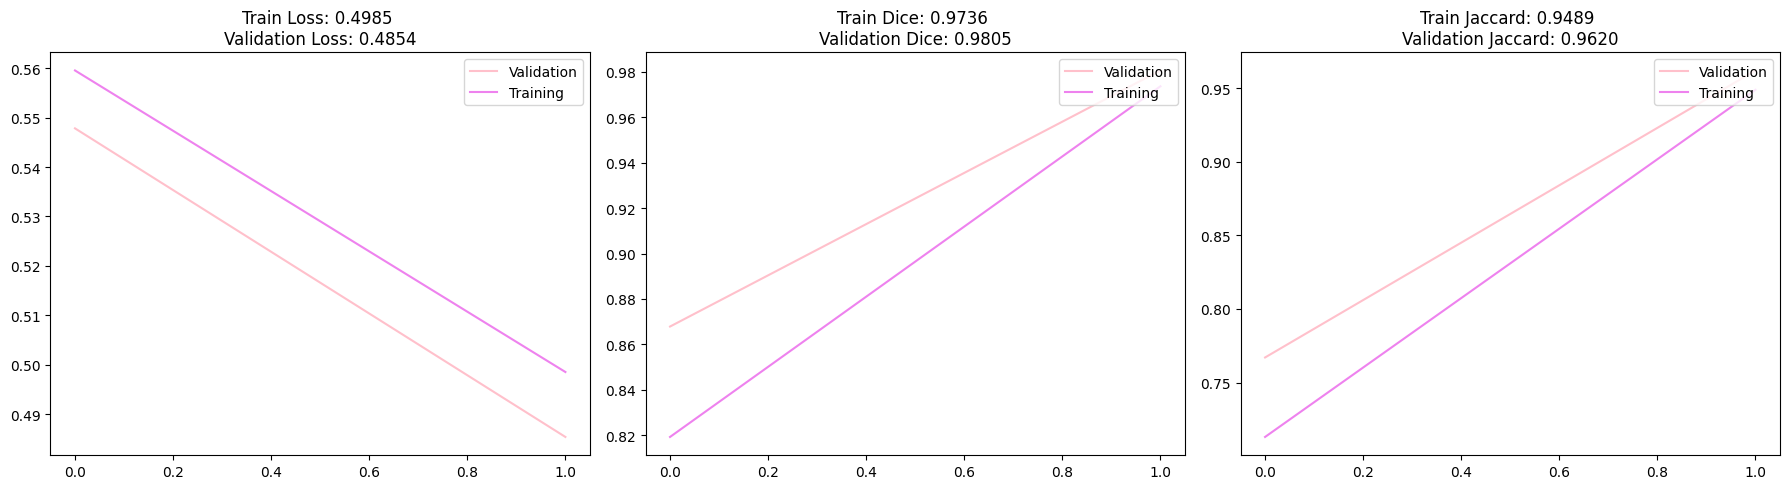

train epoch 3/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.4703 | Dice: 0.9825 | IoU: 0.9658


val epoch 3/60: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Loss: 0.4840 | Dice: 0.9831 | IoU: 0.9670


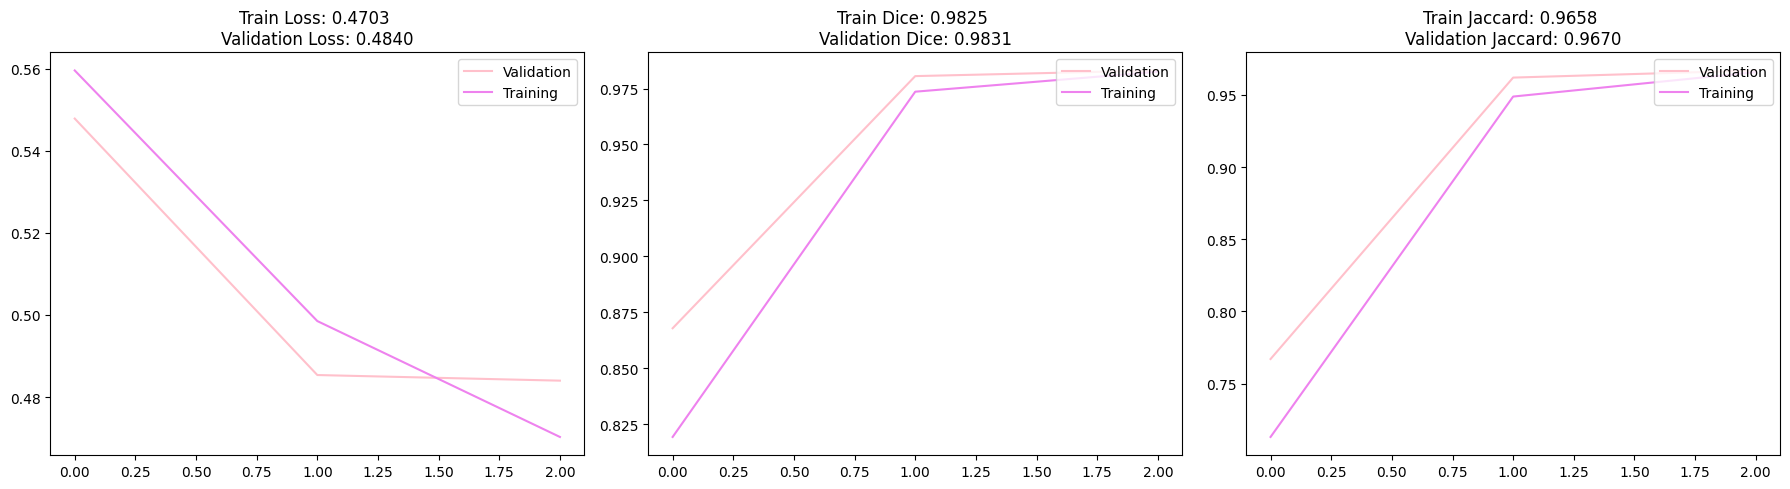

train epoch 4/60: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


Loss: 0.4383 | Dice: 0.9837 | IoU: 0.9681


val epoch 4/60: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Loss: 0.4388 | Dice: 0.9798 | IoU: 0.9607


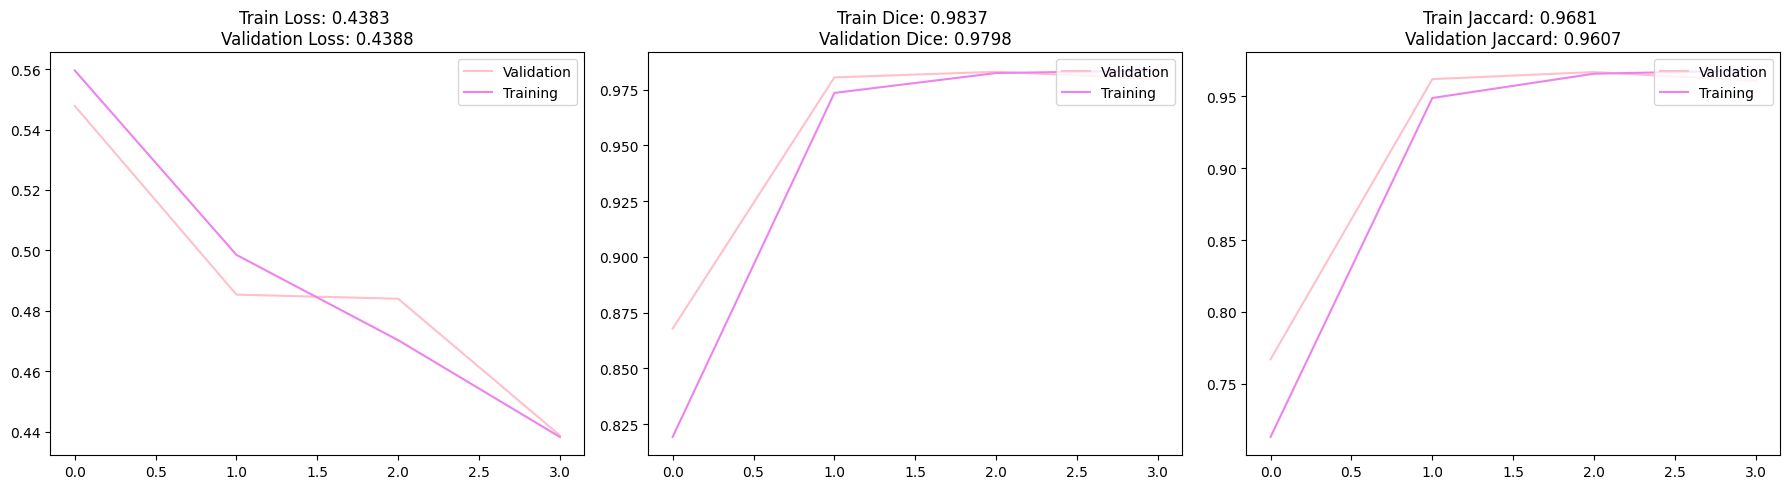

train epoch 5/60: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.4074 | Dice: 0.9838 | IoU: 0.9684


val epoch 5/60: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Loss: 0.3942 | Dice: 0.9845 | IoU: 0.9696


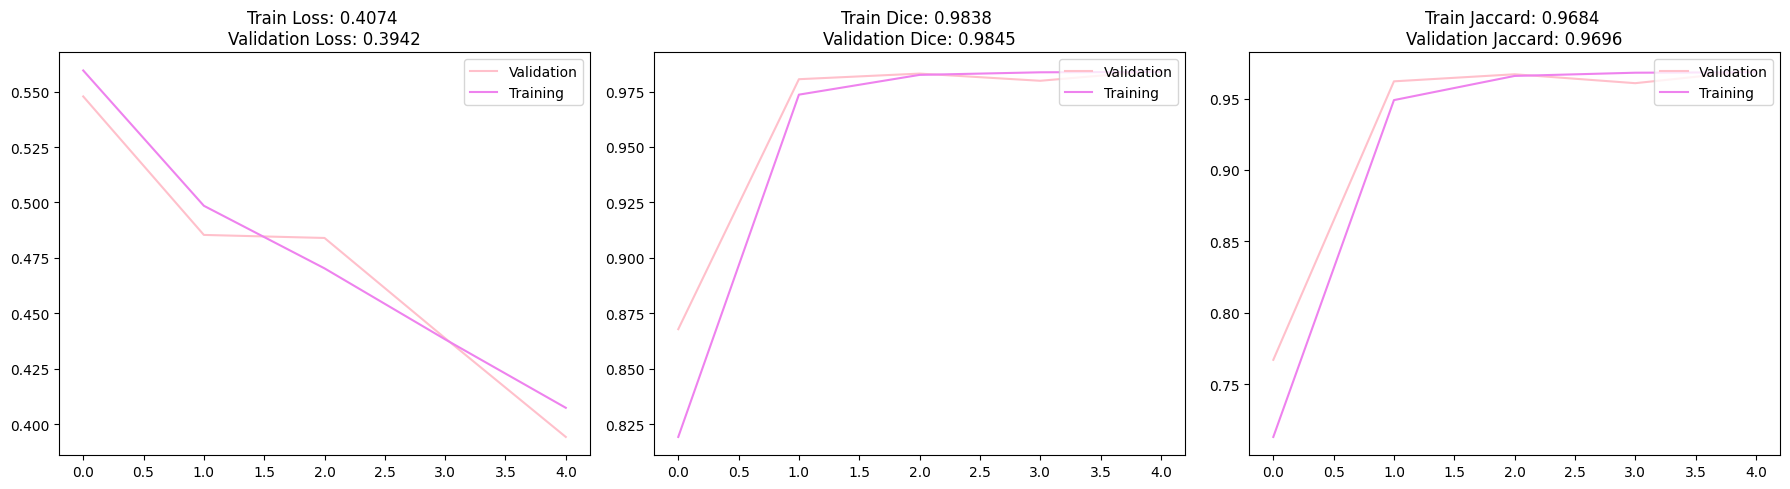

train epoch 6/60: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Loss: 0.3778 | Dice: 0.9850 | IoU: 0.9707


val epoch 6/60: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Loss: 0.3654 | Dice: 0.9861 | IoU: 0.9727


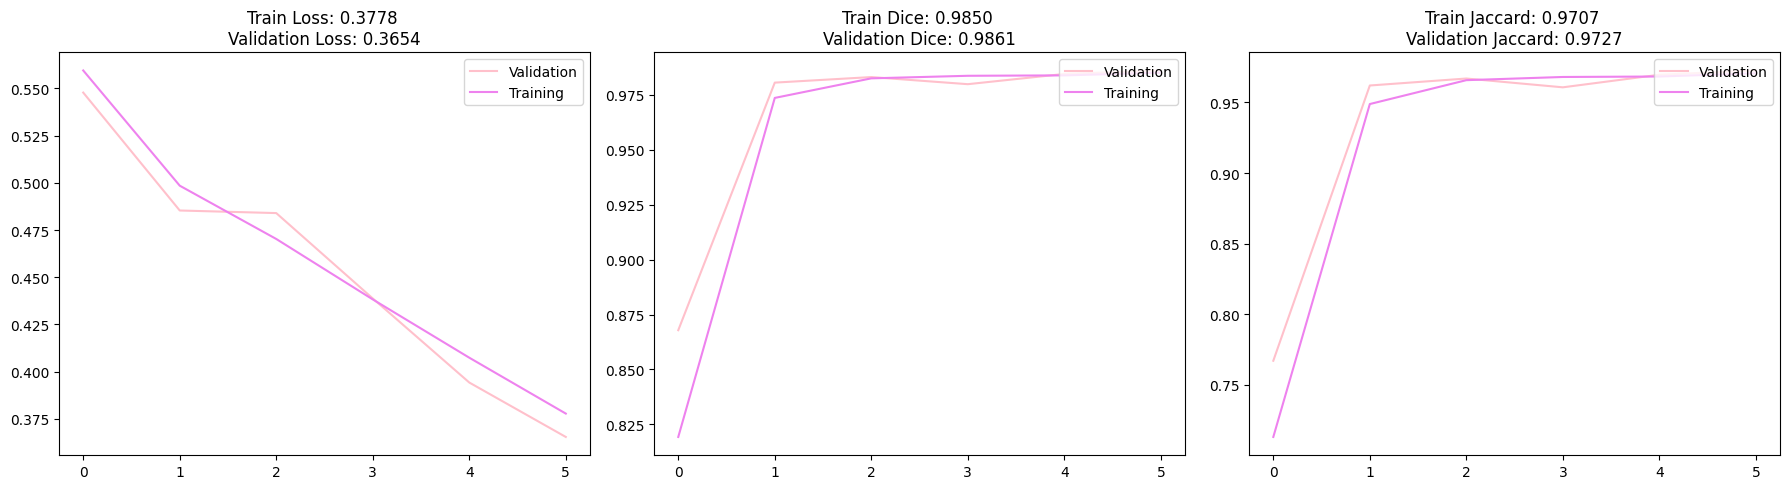

train epoch 7/60: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


Loss: 0.3495 | Dice: 0.9858 | IoU: 0.9721


val epoch 7/60: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Loss: 0.3455 | Dice: 0.9824 | IoU: 0.9658


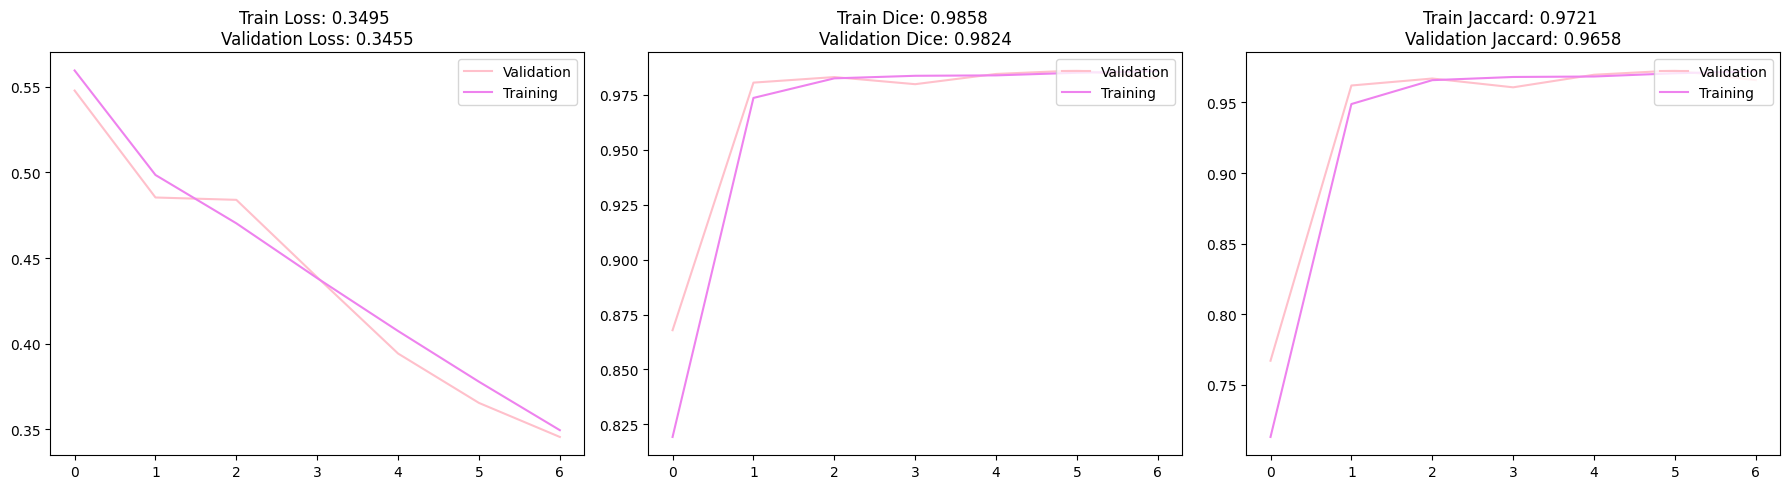

train epoch 8/60: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.3244 | Dice: 0.9844 | IoU: 0.9695


val epoch 8/60: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Loss: 0.3394 | Dice: 0.9877 | IoU: 0.9759


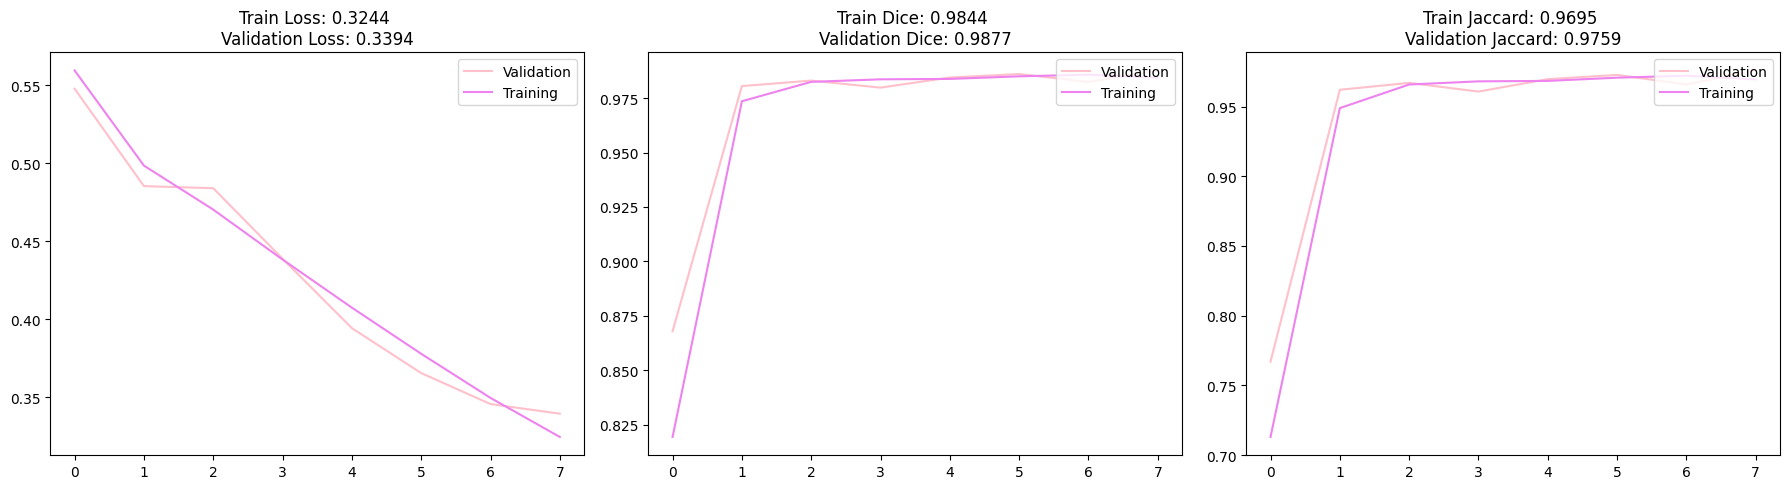

train epoch 9/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.2997 | Dice: 0.9847 | IoU: 0.9701


val epoch 9/60: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Loss: 0.2863 | Dice: 0.9835 | IoU: 0.9678


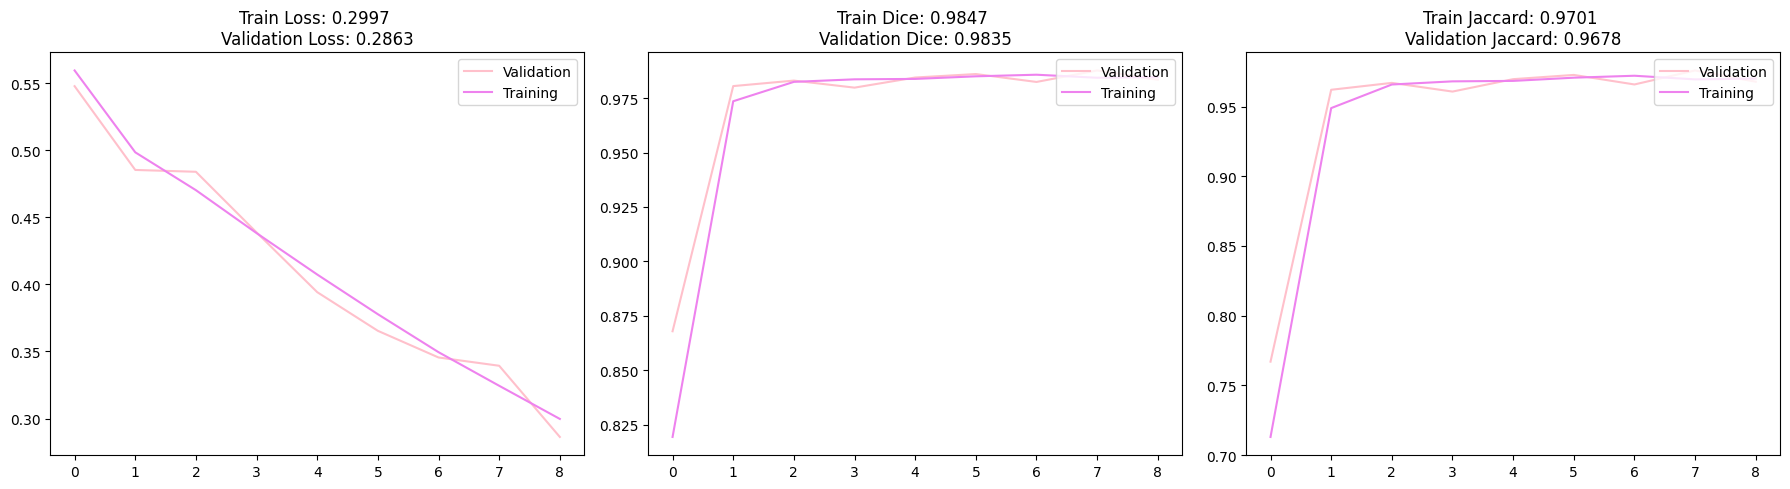

train epoch 10/60: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Loss: 0.2744 | Dice: 0.9863 | IoU: 0.9732


val epoch 10/60: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Loss: 0.2635 | Dice: 0.9841 | IoU: 0.9692


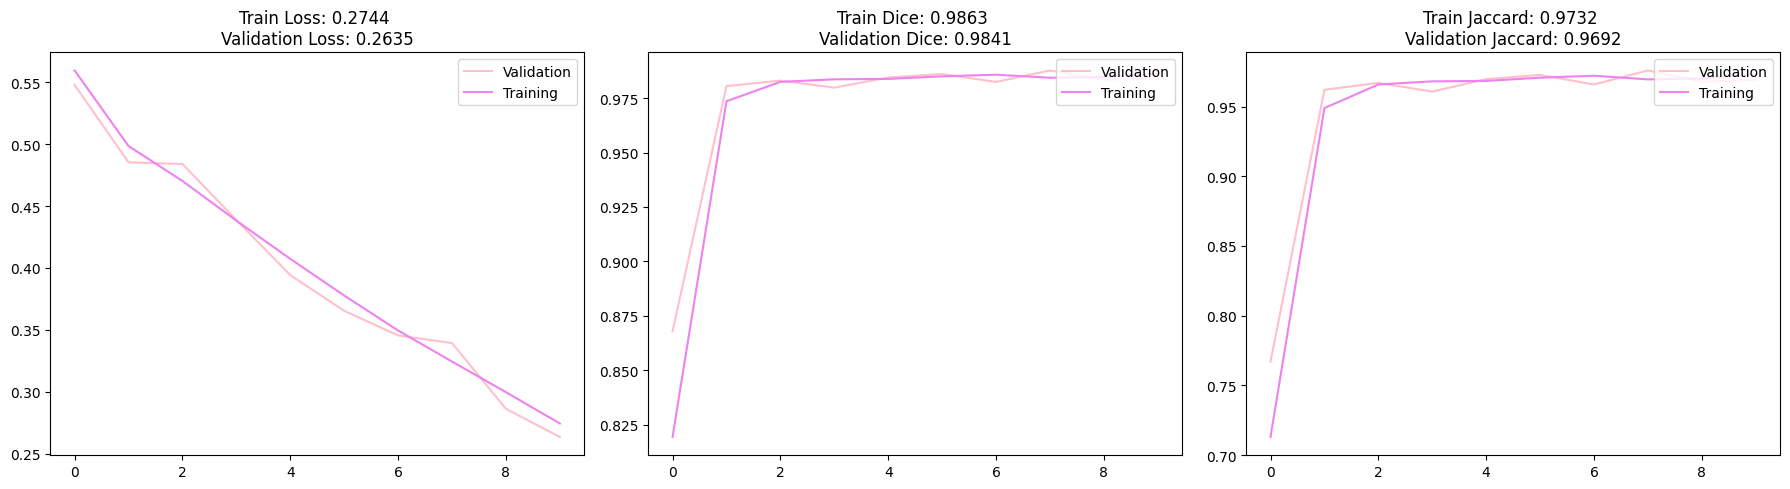

train epoch 11/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.2507 | Dice: 0.9862 | IoU: 0.9729


val epoch 11/60: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Loss: 0.2393 | Dice: 0.9856 | IoU: 0.9718


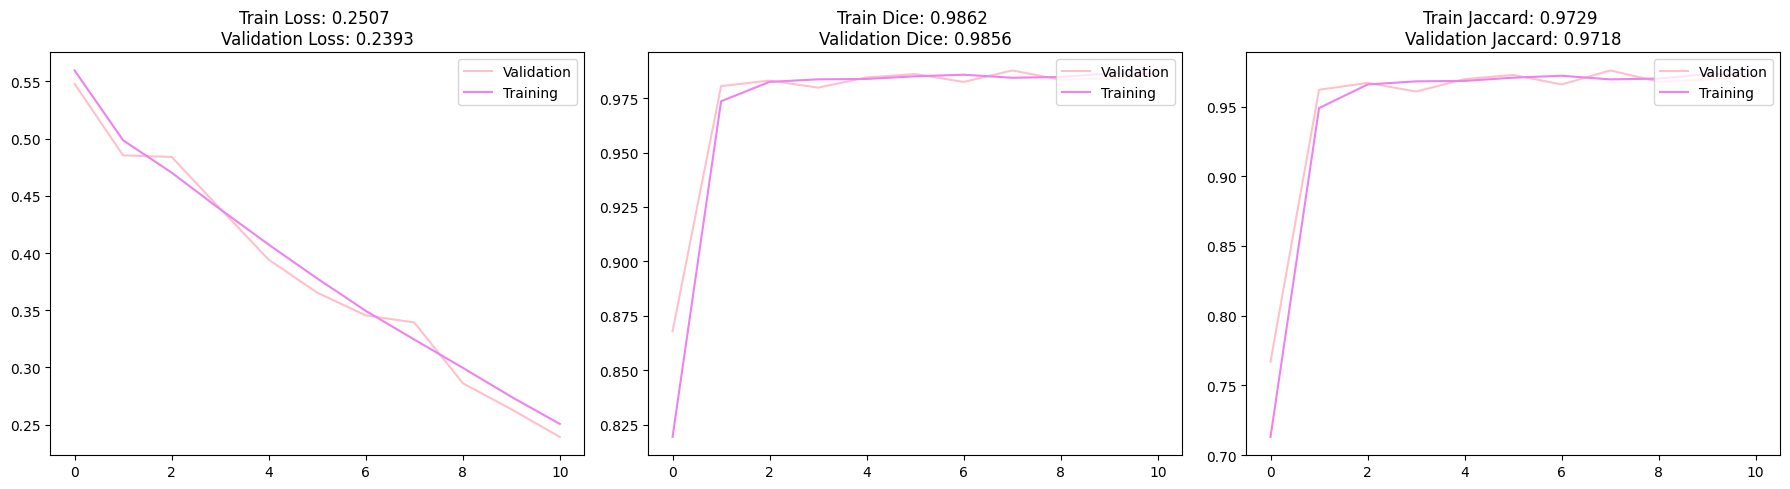

train epoch 12/60: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.2284 | Dice: 0.9872 | IoU: 0.9749


val epoch 12/60: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Loss: 0.2087 | Dice: 0.9873 | IoU: 0.9751


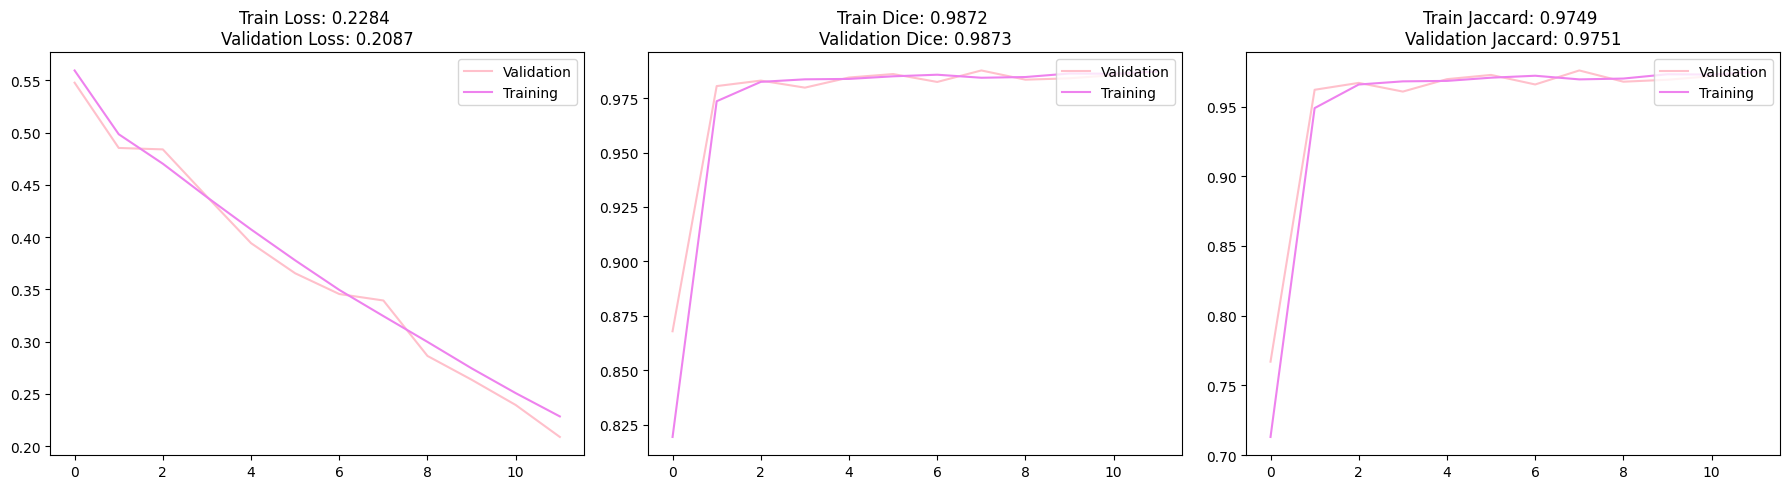

train epoch 13/60: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.2083 | Dice: 0.9869 | IoU: 0.9743


val epoch 13/60: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Loss: 0.1968 | Dice: 0.9881 | IoU: 0.9767


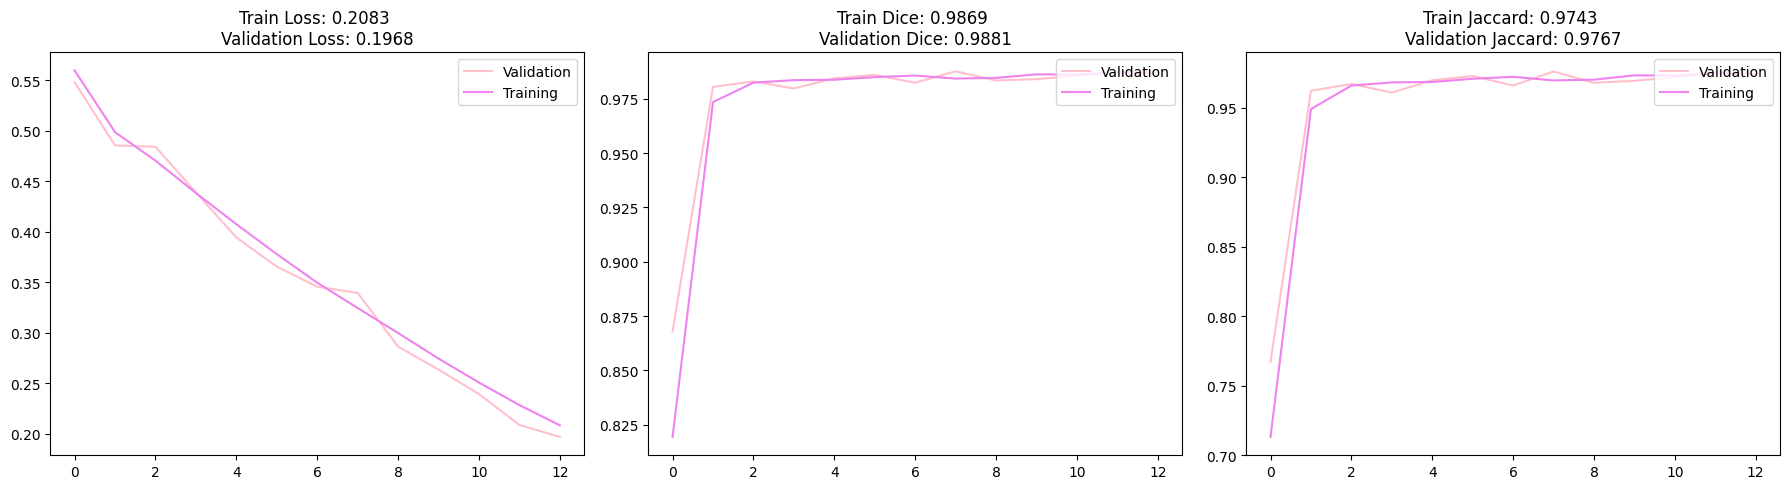

train epoch 14/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.1902 | Dice: 0.9871 | IoU: 0.9747


val epoch 14/60: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Loss: 0.1808 | Dice: 0.9867 | IoU: 0.9740


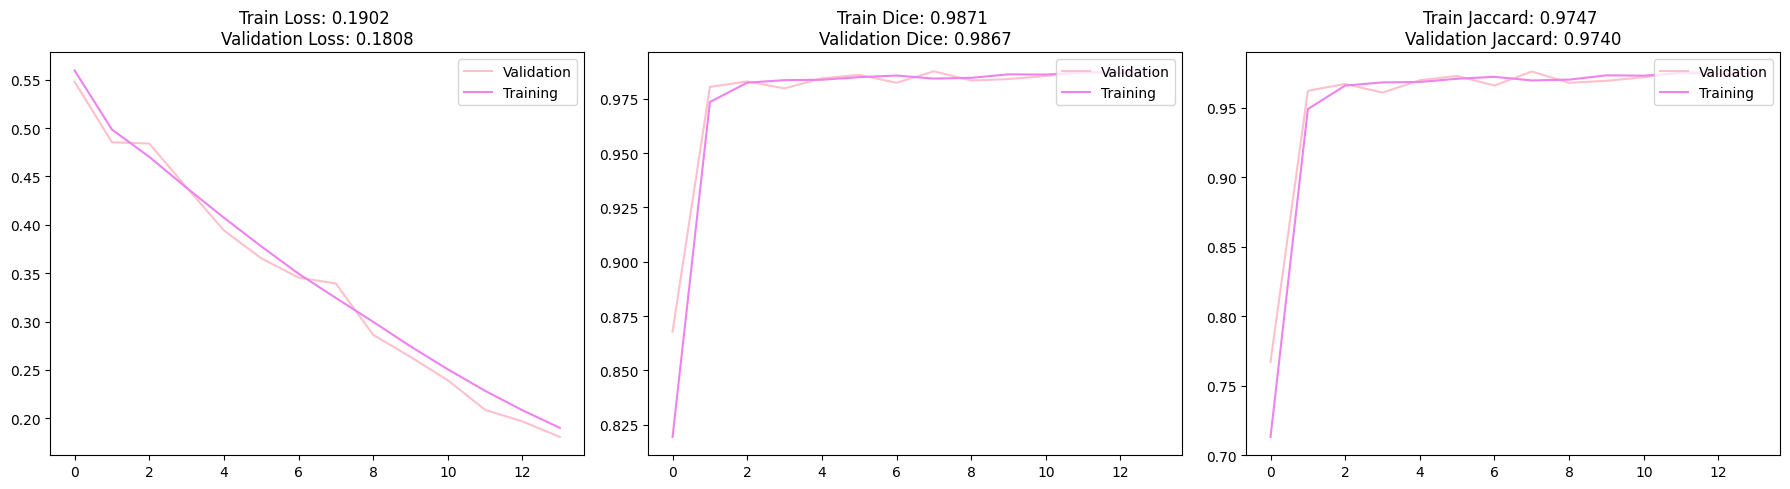

train epoch 15/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.1729 | Dice: 0.9876 | IoU: 0.9757


val epoch 15/60: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Loss: 0.1554 | Dice: 0.9856 | IoU: 0.9717


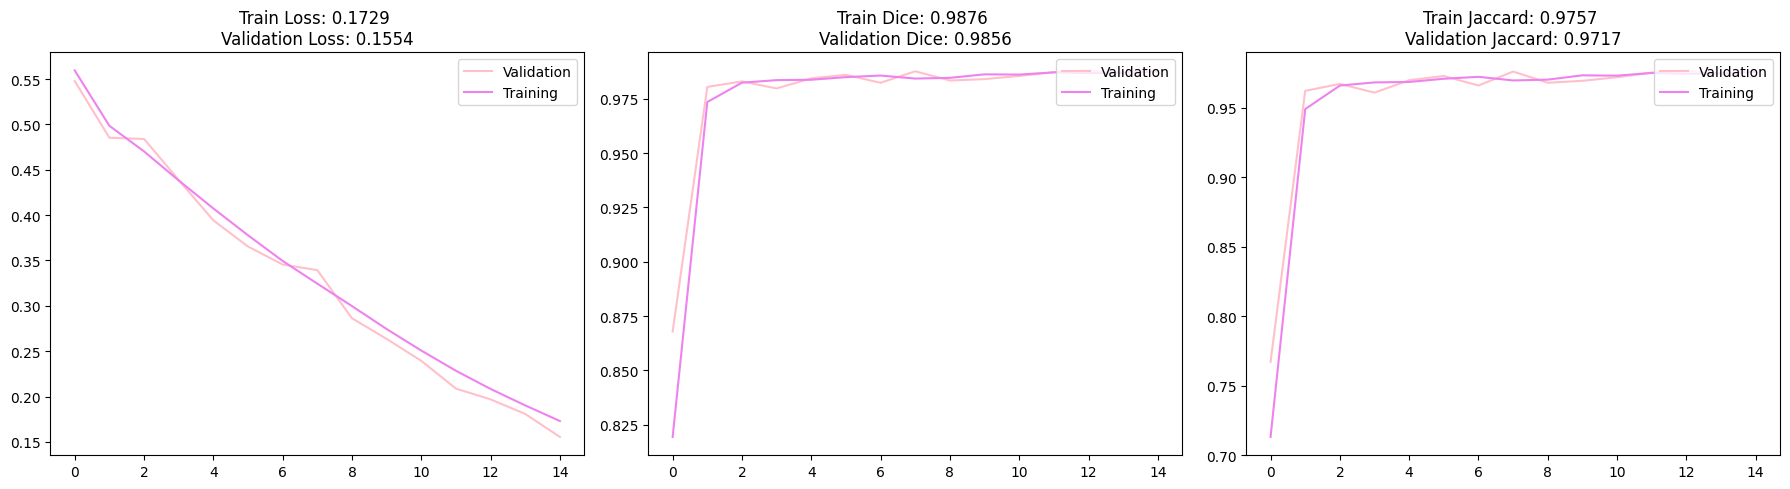

train epoch 16/60: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Loss: 0.1580 | Dice: 0.9882 | IoU: 0.9767


val epoch 16/60: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Loss: 0.1528 | Dice: 0.9874 | IoU: 0.9753


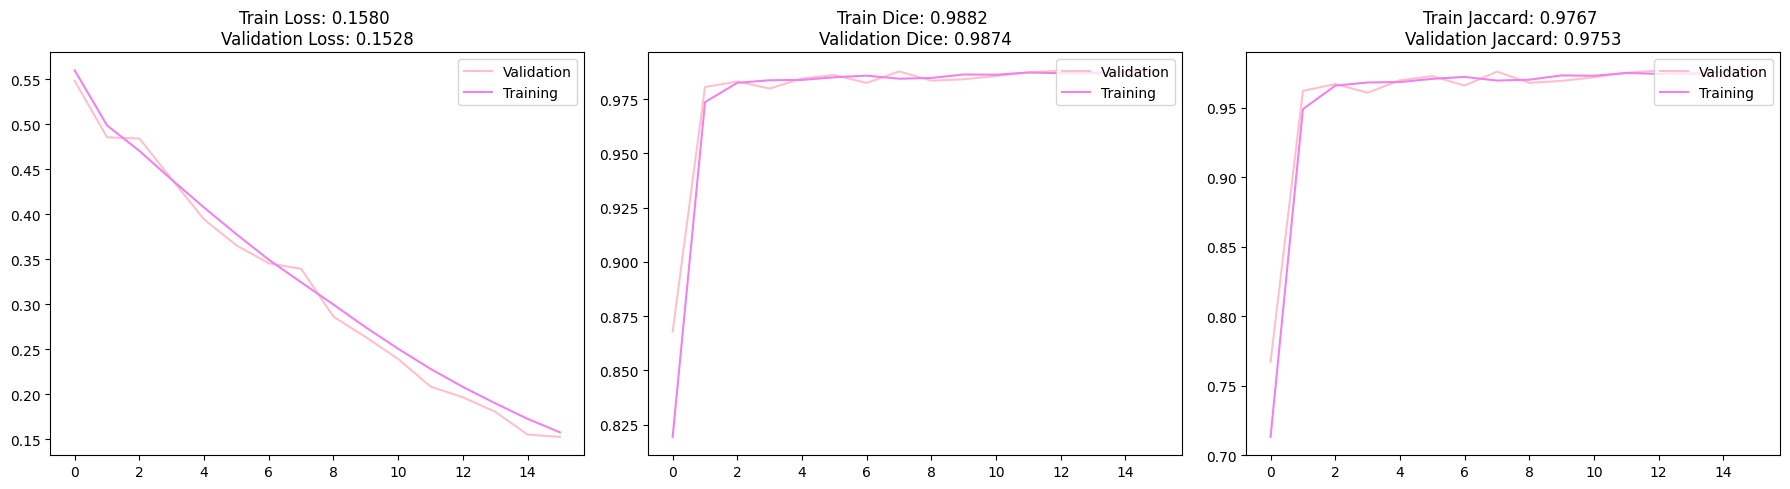

train epoch 17/60: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.1444 | Dice: 0.9887 | IoU: 0.9778


val epoch 17/60: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Loss: 0.1273 | Dice: 0.9884 | IoU: 0.9771


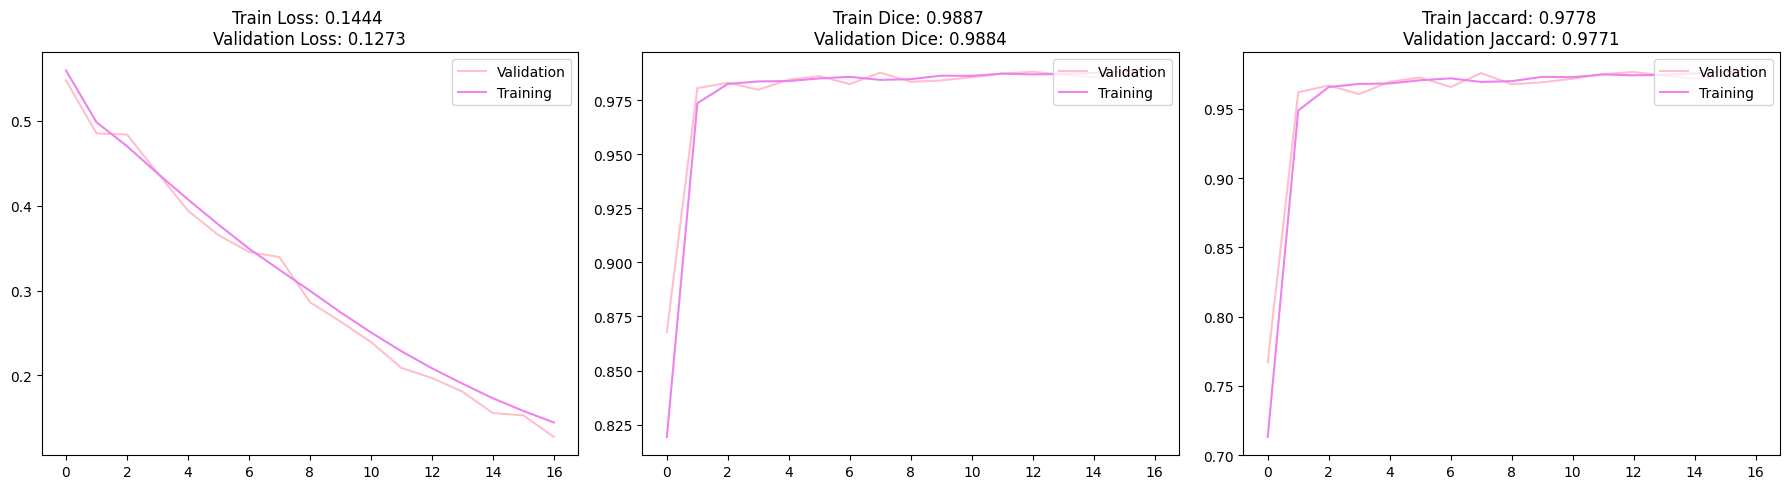

train epoch 18/60: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


Loss: 0.1329 | Dice: 0.9885 | IoU: 0.9774


val epoch 18/60: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Loss: 0.1264 | Dice: 0.9876 | IoU: 0.9757


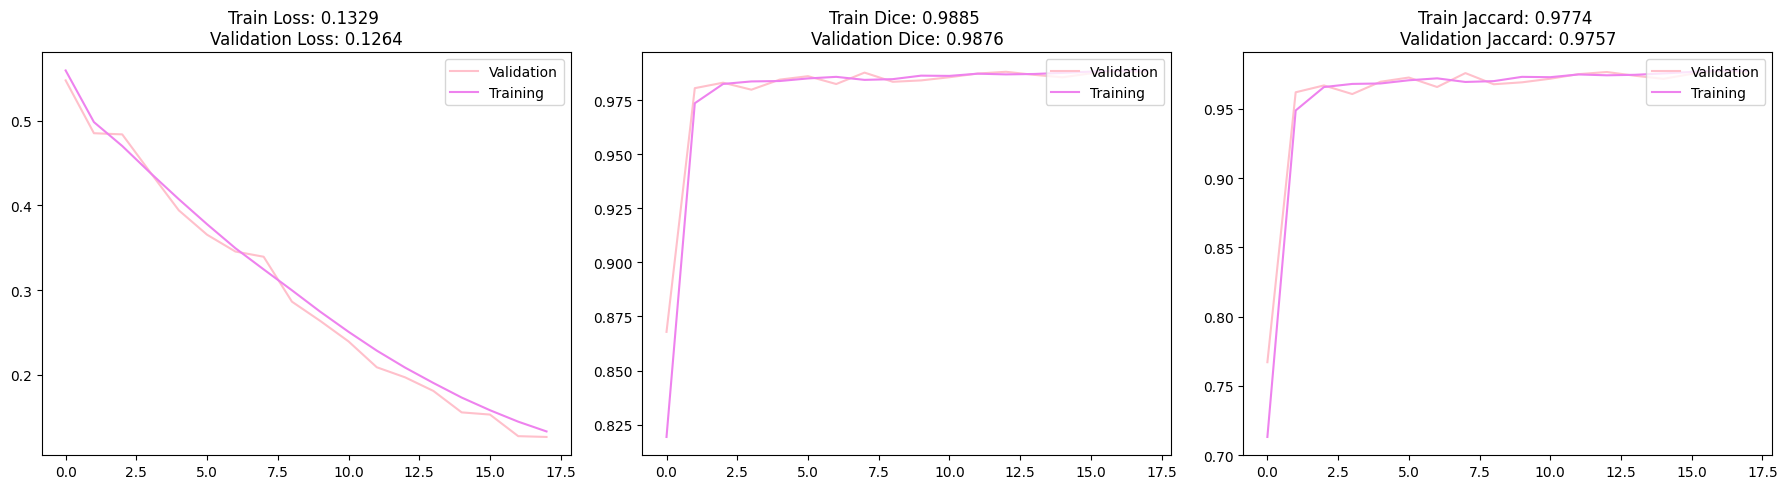

train epoch 19/60: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.1220 | Dice: 0.9891 | IoU: 0.9786


val epoch 19/60: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Loss: 0.1197 | Dice: 0.9864 | IoU: 0.9734


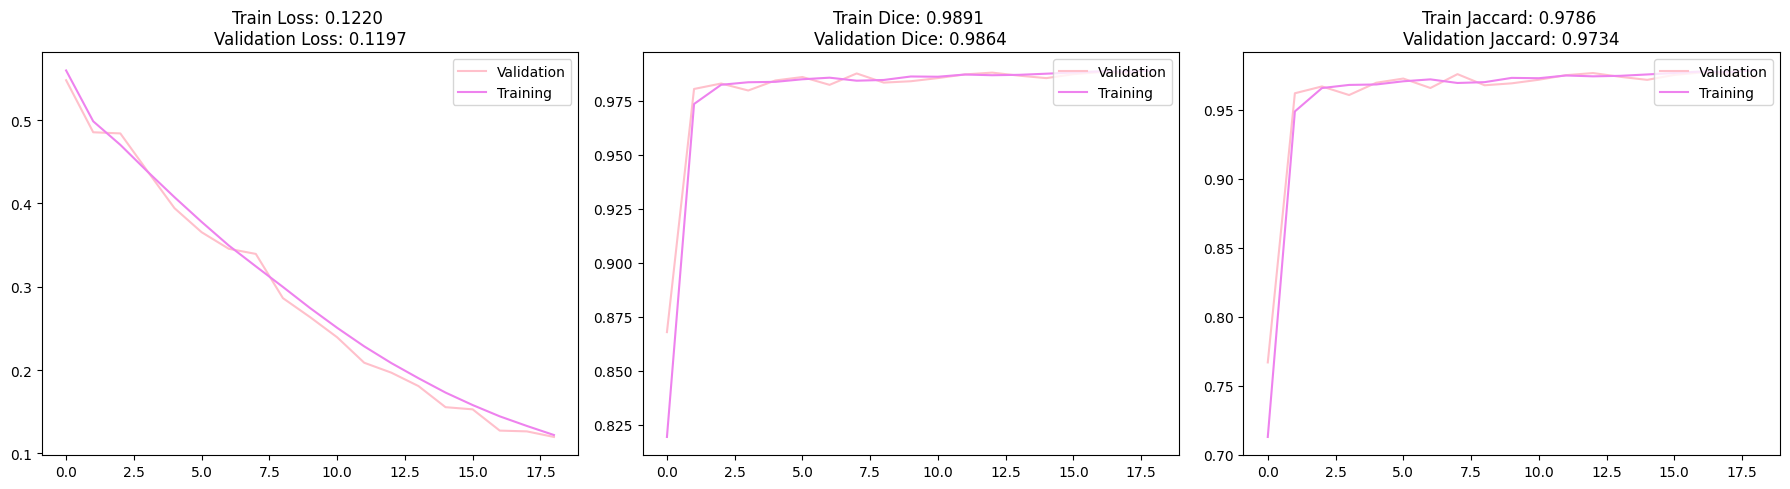

train epoch 20/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.1127 | Dice: 0.9887 | IoU: 0.9777


val epoch 20/60: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Loss: 0.1103 | Dice: 0.9859 | IoU: 0.9723


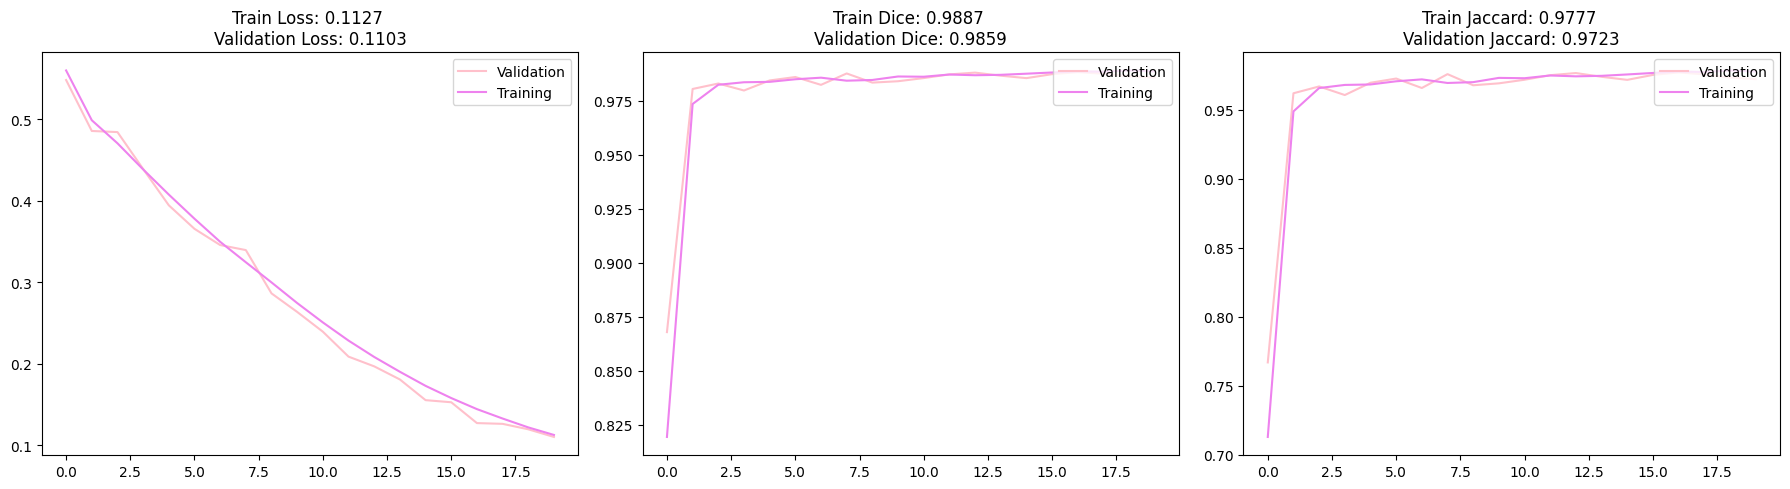

train epoch 21/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.1040 | Dice: 0.9891 | IoU: 0.9785


val epoch 21/60: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Loss: 0.1046 | Dice: 0.9873 | IoU: 0.9752


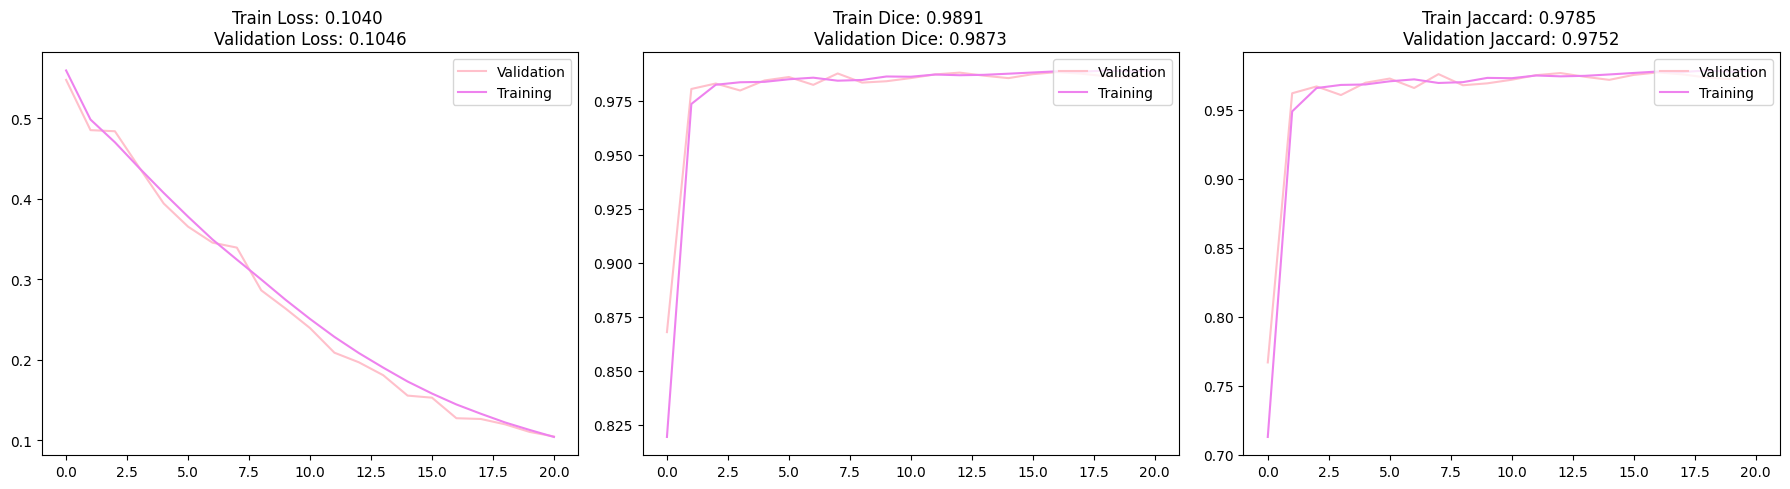

train epoch 22/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0958 | Dice: 0.9897 | IoU: 0.9797


val epoch 22/60: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Loss: 0.0941 | Dice: 0.9876 | IoU: 0.9757


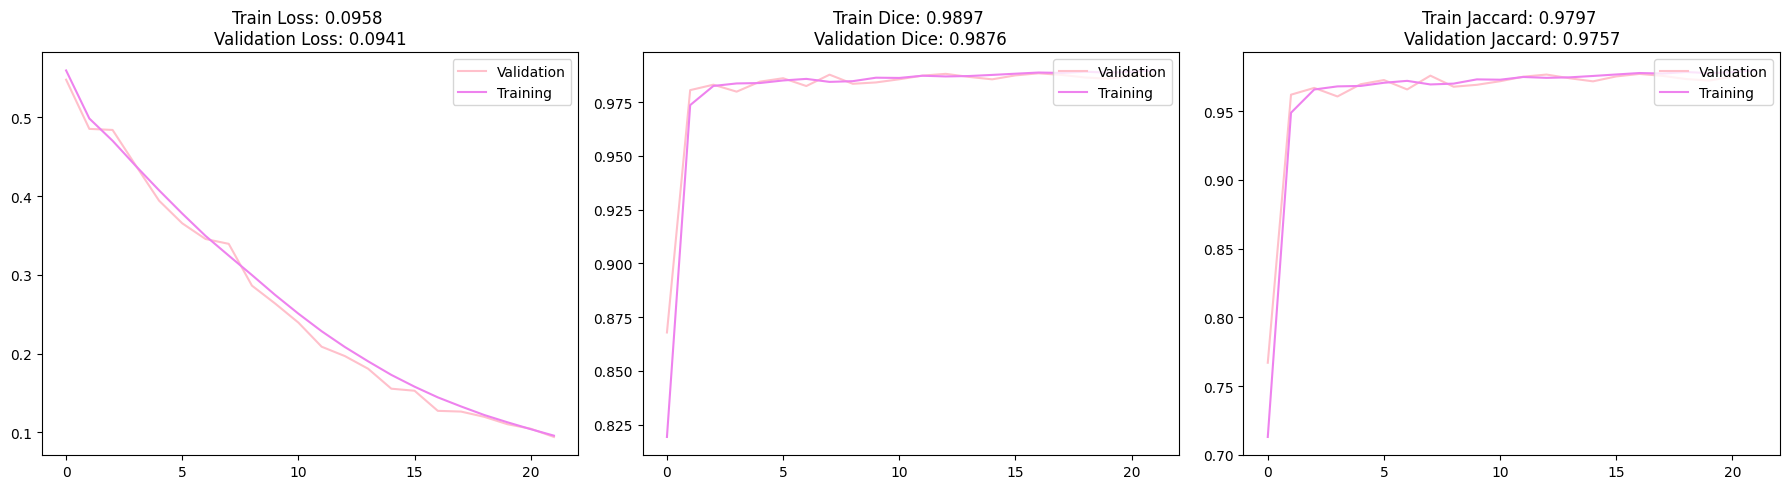

train epoch 23/60: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.0890 | Dice: 0.9898 | IoU: 0.9799


val epoch 23/60: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Loss: 0.0808 | Dice: 0.9884 | IoU: 0.9773


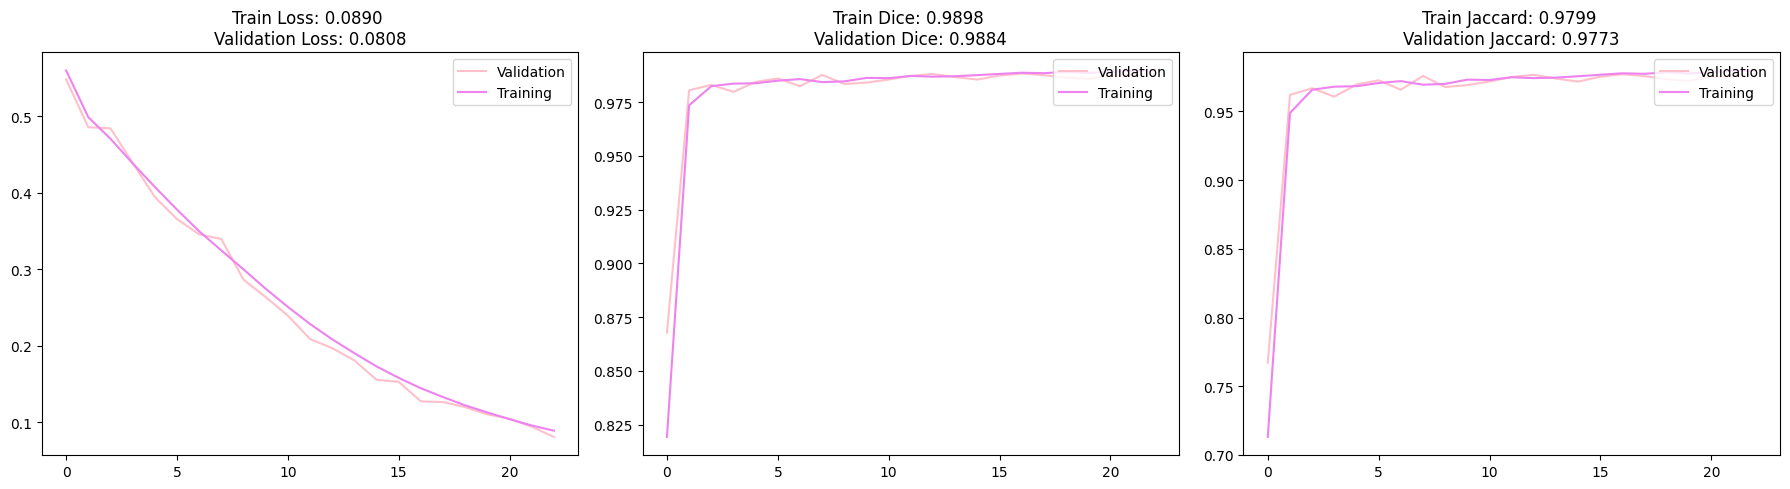

train epoch 24/60: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.0832 | Dice: 0.9896 | IoU: 0.9794


val epoch 24/60: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Loss: 0.0789 | Dice: 0.9883 | IoU: 0.9770


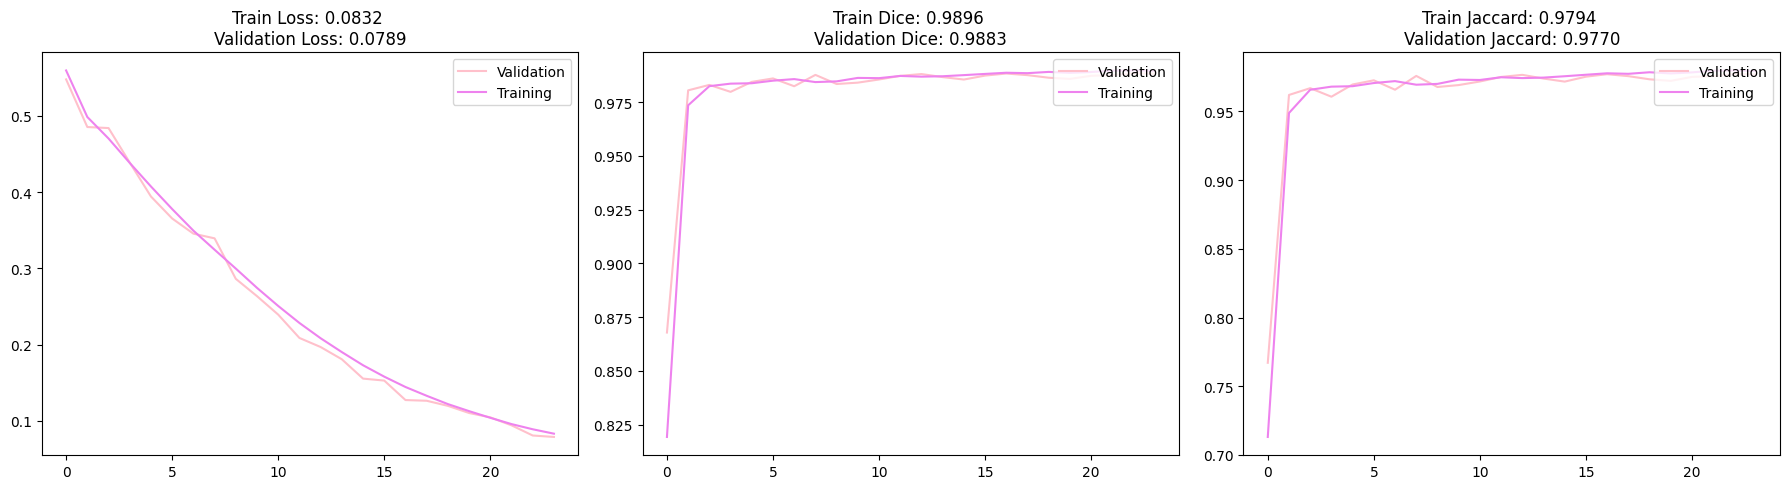

train epoch 25/60: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.0782 | Dice: 0.9893 | IoU: 0.9788


val epoch 25/60: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Loss: 0.0742 | Dice: 0.9883 | IoU: 0.9771


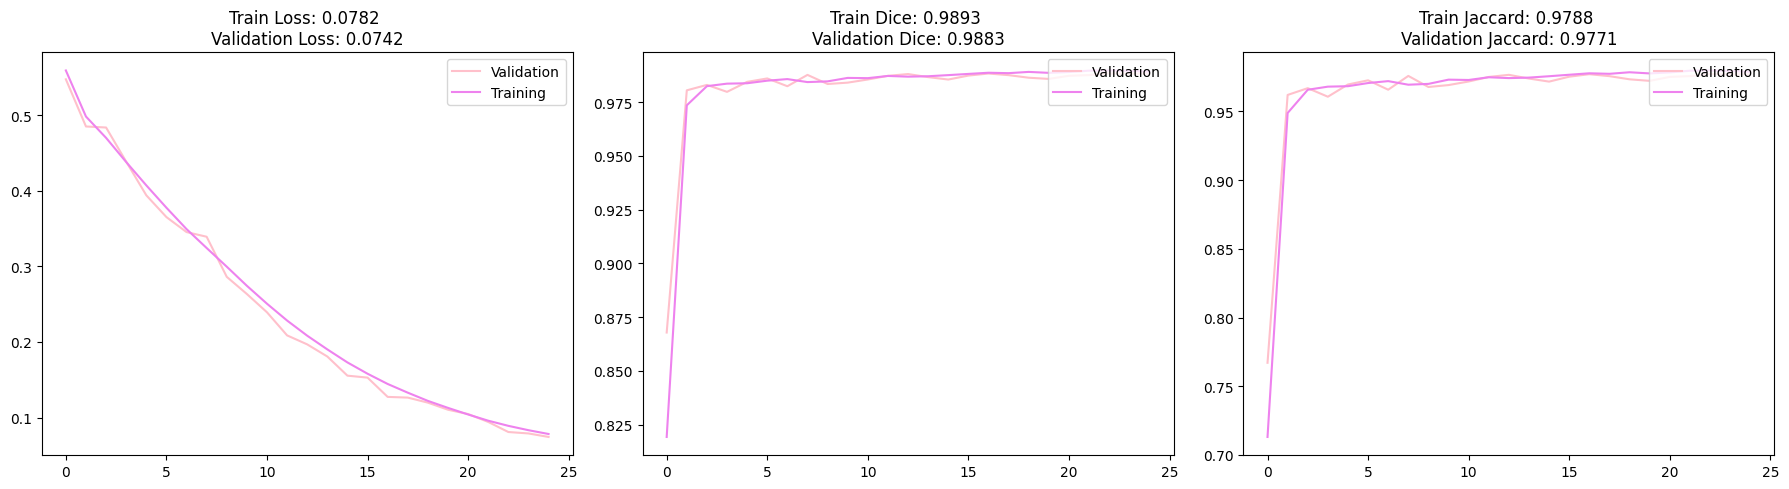

train epoch 26/60: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.0735 | Dice: 0.9889 | IoU: 0.9781


val epoch 26/60: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Loss: 0.0653 | Dice: 0.9862 | IoU: 0.9730


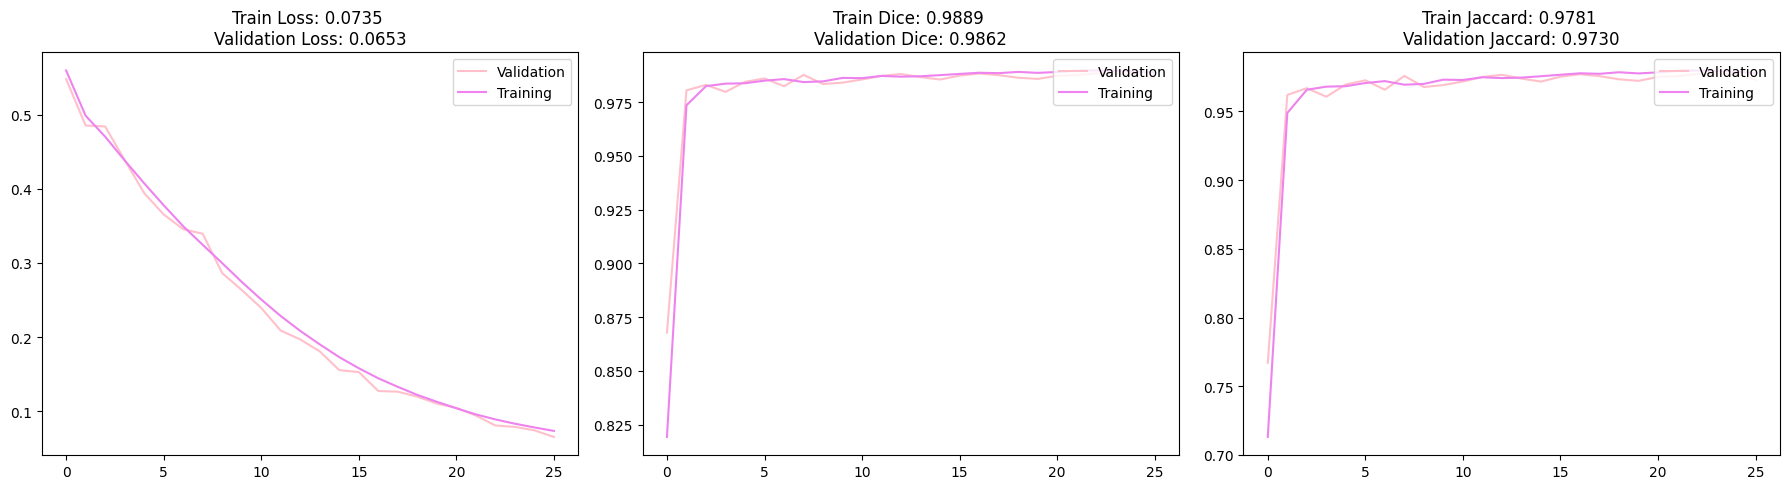

train epoch 27/60: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.0682 | Dice: 0.9896 | IoU: 0.9795


val epoch 27/60: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Loss: 0.0675 | Dice: 0.9887 | IoU: 0.9778


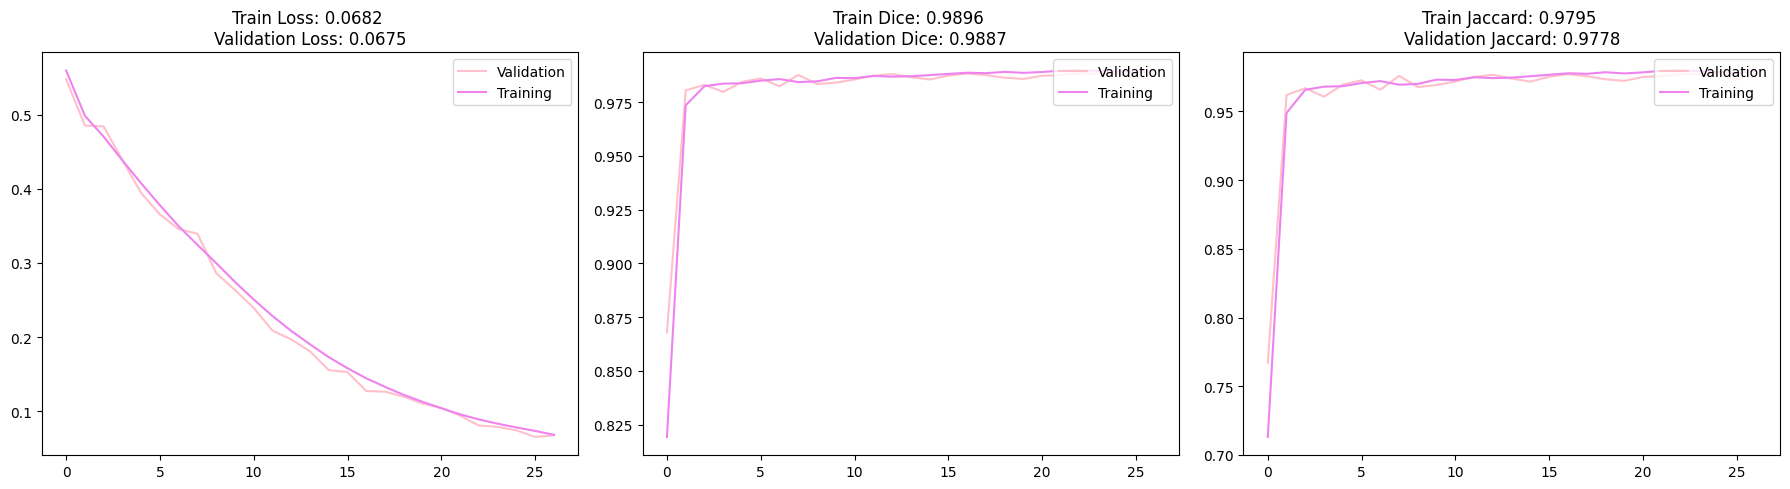

train epoch 28/60: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Loss: 0.0638 | Dice: 0.9901 | IoU: 0.9804


val epoch 28/60: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Loss: 0.0660 | Dice: 0.9866 | IoU: 0.9739


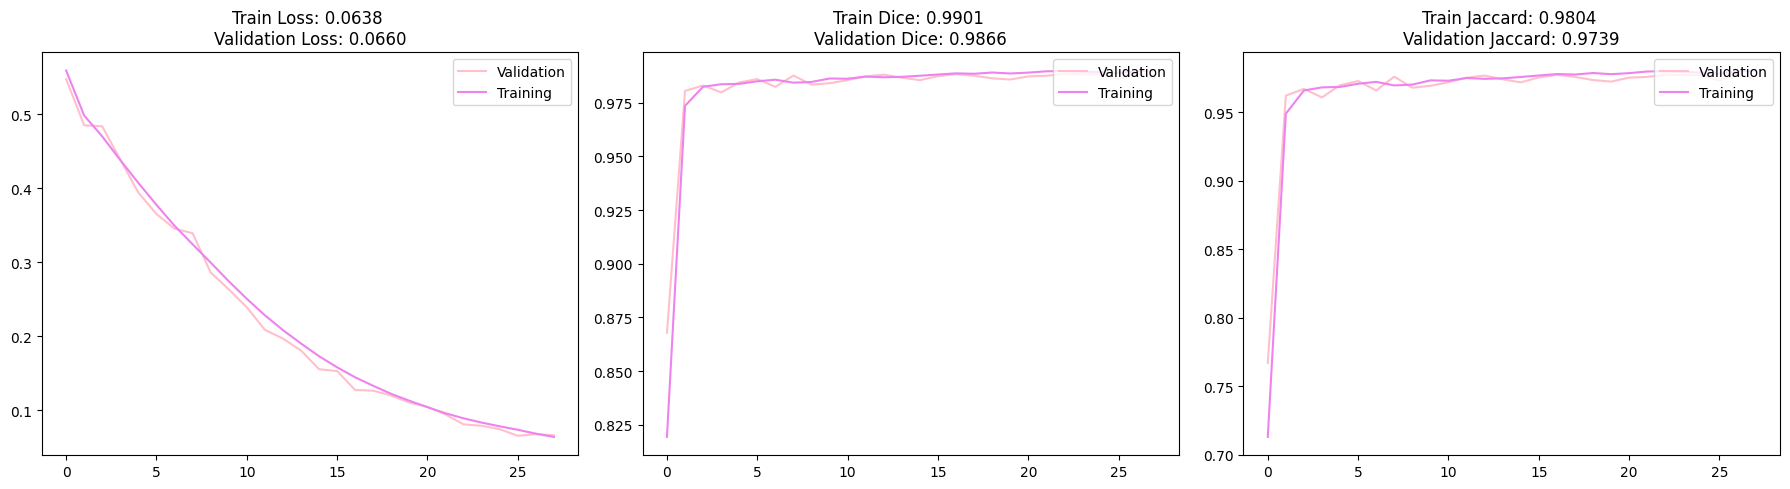

train epoch 29/60: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


Loss: 0.0602 | Dice: 0.9901 | IoU: 0.9804


val epoch 29/60: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Loss: 0.0562 | Dice: 0.9881 | IoU: 0.9766


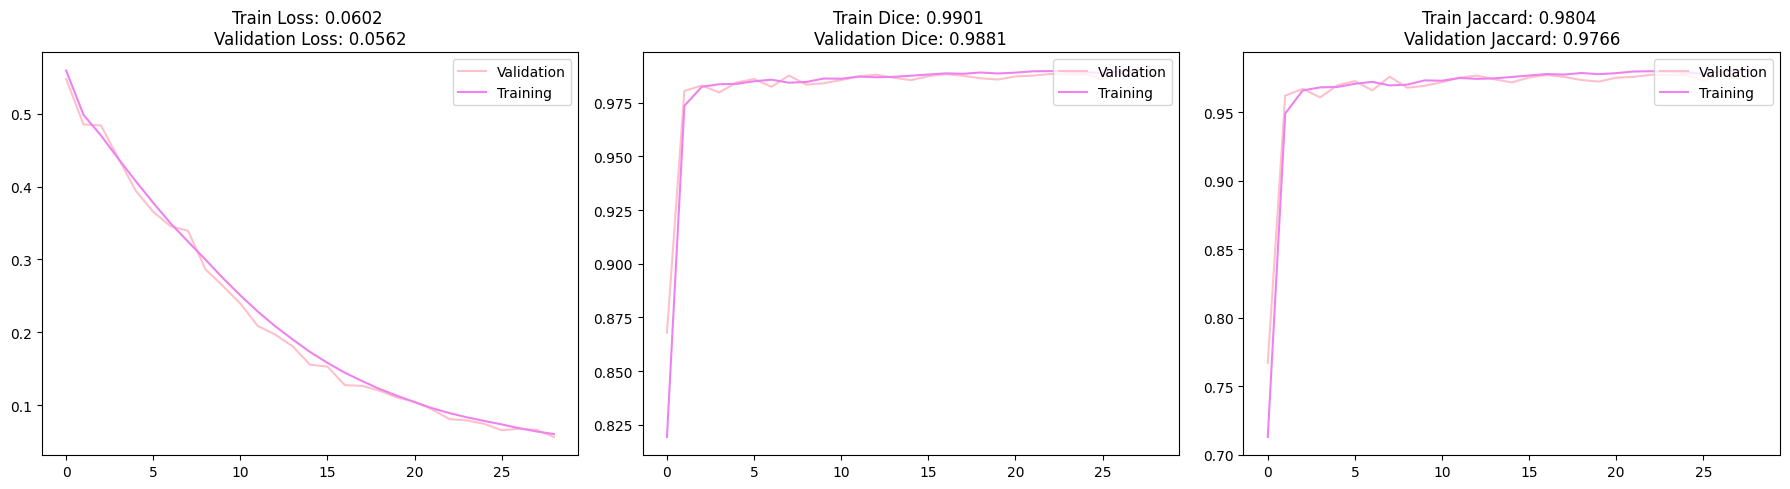

train epoch 30/60: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.0561 | Dice: 0.9907 | IoU: 0.9816


val epoch 30/60: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Loss: 0.0575 | Dice: 0.9871 | IoU: 0.9749


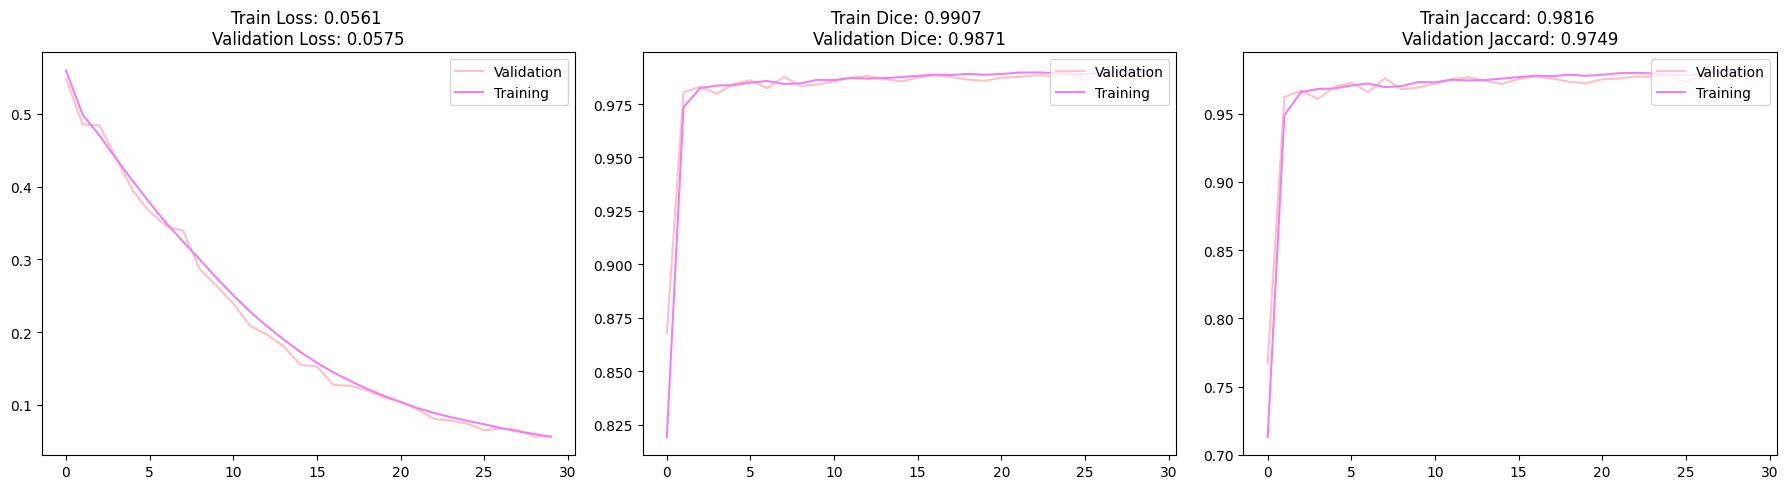

train epoch 31/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0543 | Dice: 0.9896 | IoU: 0.9795


val epoch 31/60: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Loss: 0.0544 | Dice: 0.9876 | IoU: 0.9756


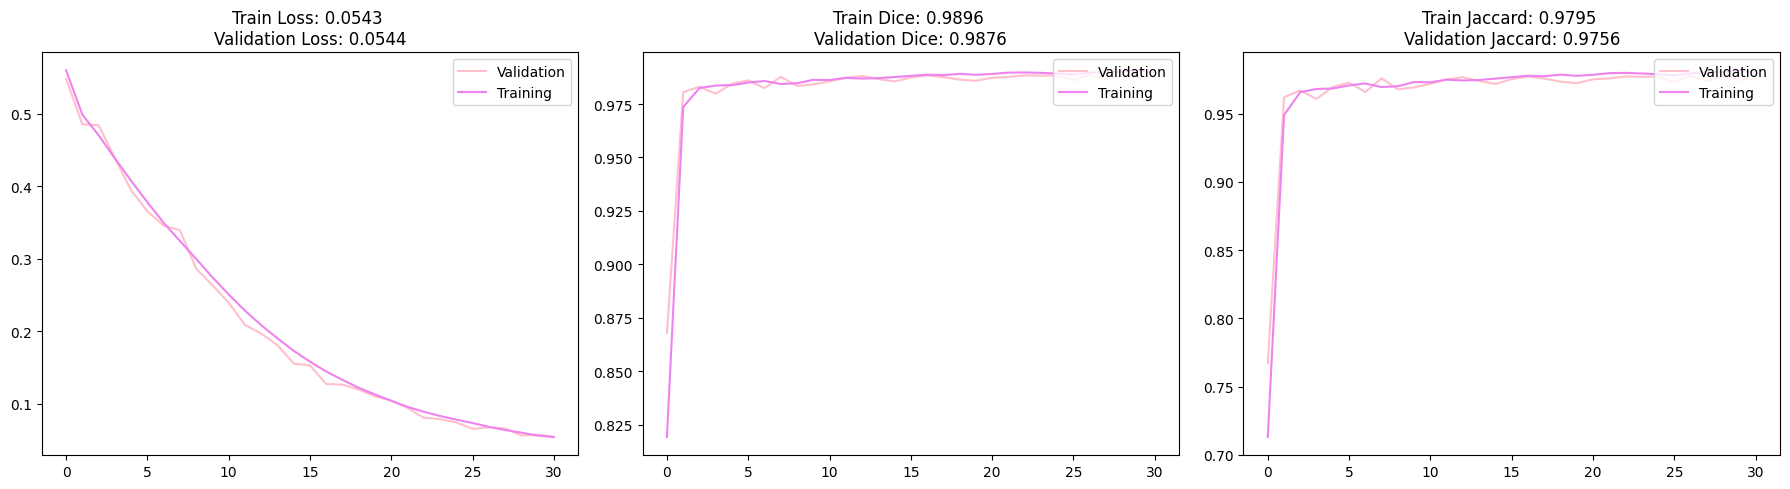

train epoch 32/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0506 | Dice: 0.9905 | IoU: 0.9811


val epoch 32/60: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Loss: 0.0513 | Dice: 0.9879 | IoU: 0.9763


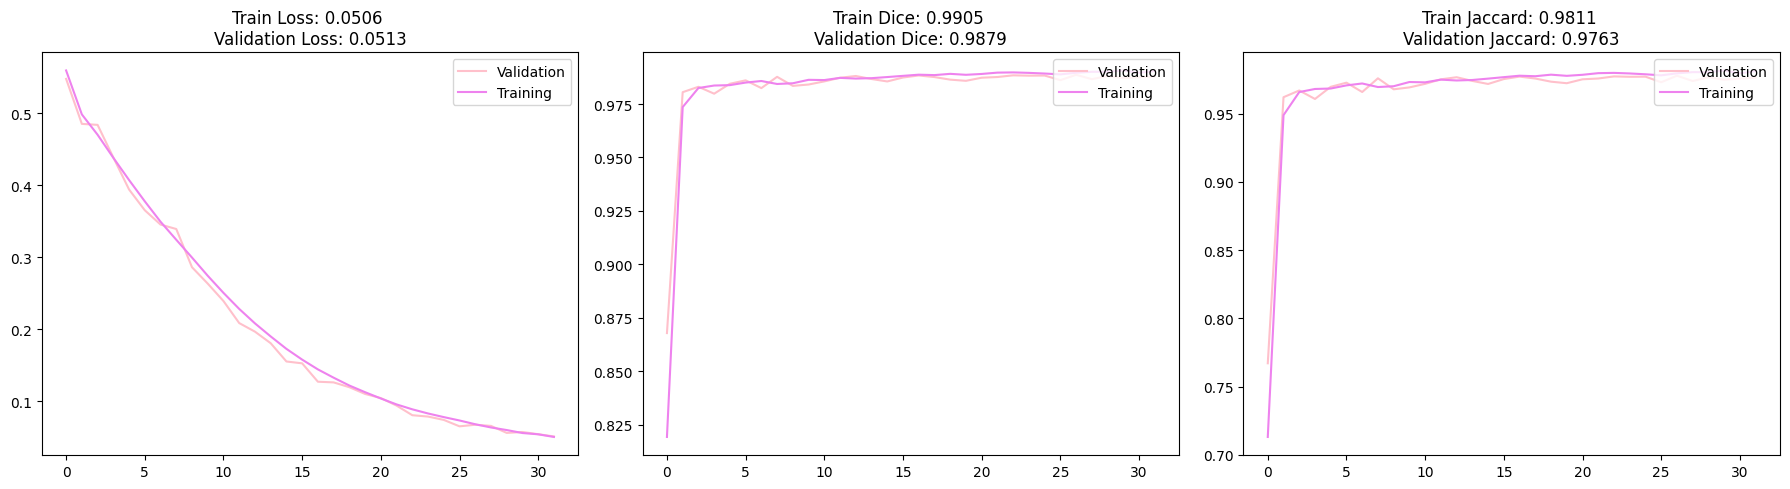

train epoch 33/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0476 | Dice: 0.9908 | IoU: 0.9819


val epoch 33/60: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Loss: 0.0479 | Dice: 0.9883 | IoU: 0.9770


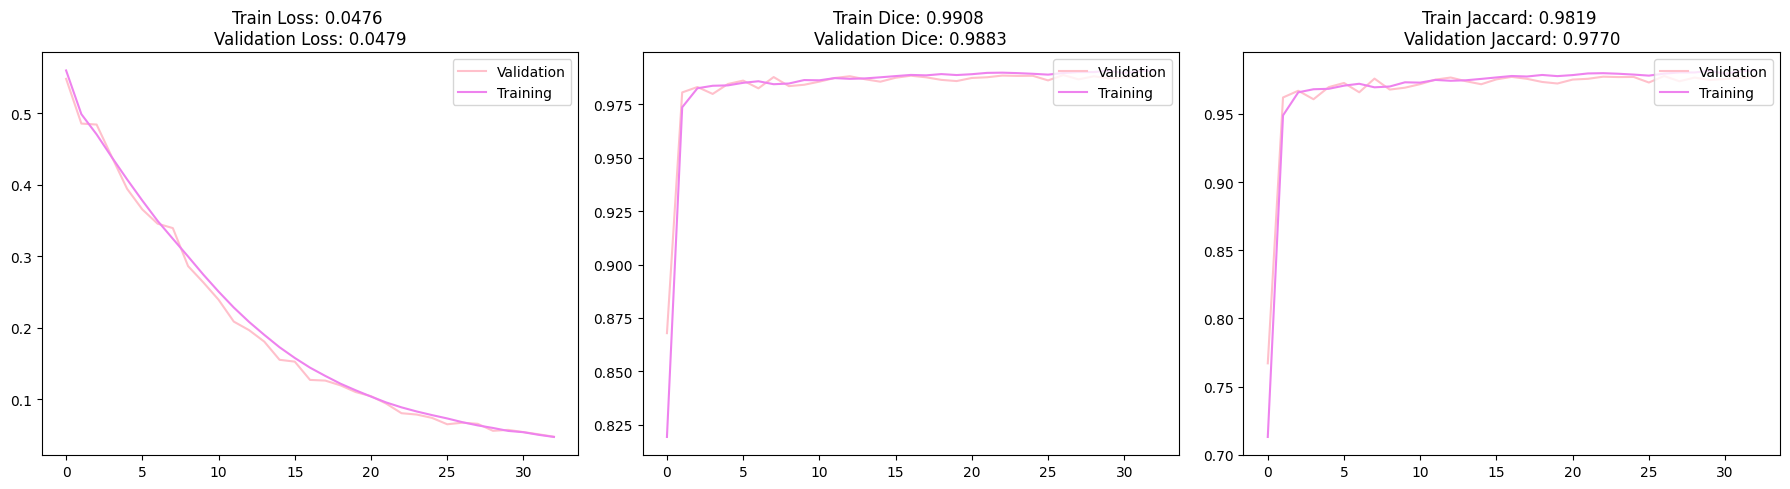

train epoch 34/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0448 | Dice: 0.9913 | IoU: 0.9829


val epoch 34/60: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Loss: 0.0465 | Dice: 0.9887 | IoU: 0.9778


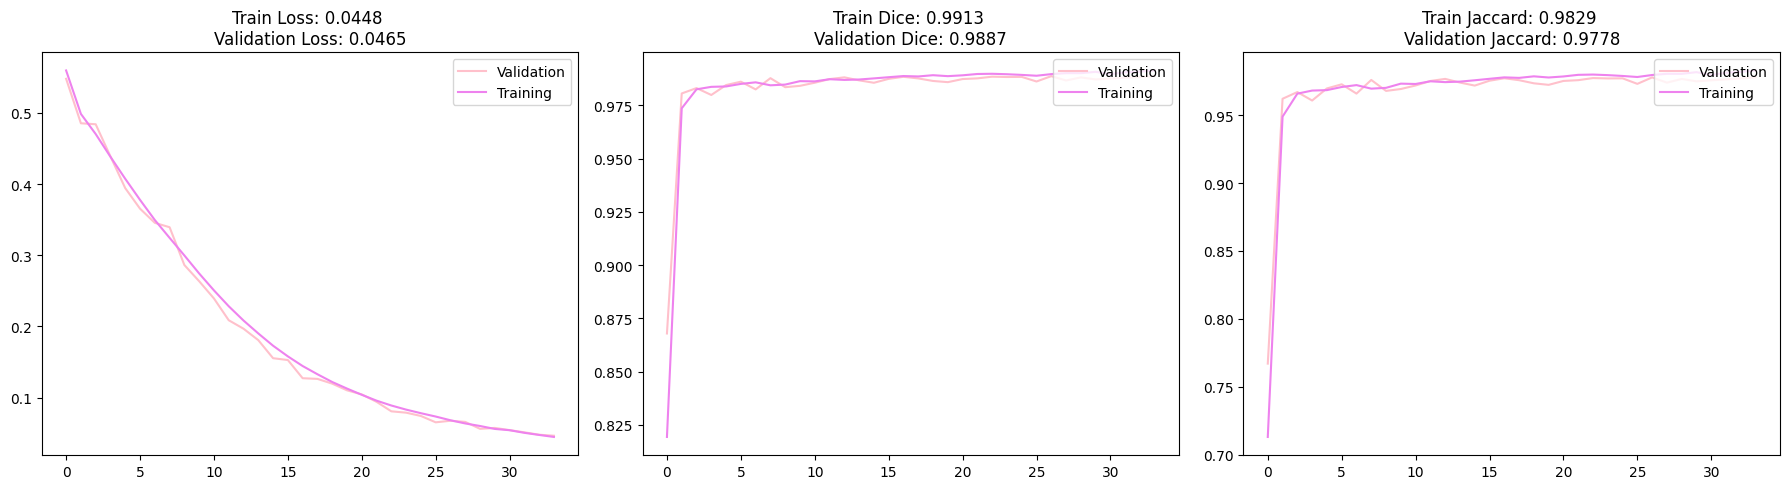

train epoch 35/60: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


Loss: 0.0429 | Dice: 0.9911 | IoU: 0.9825


val epoch 35/60: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Loss: 0.0423 | Dice: 0.9882 | IoU: 0.9769


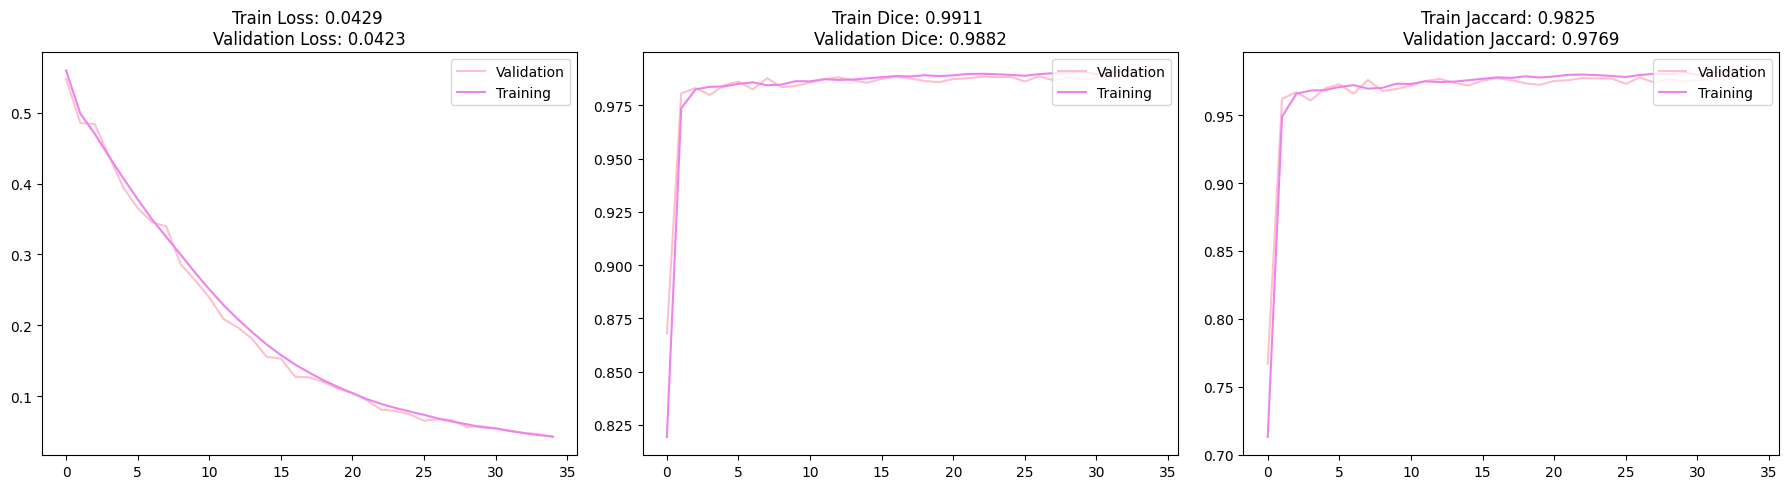

train epoch 36/60: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.0407 | Dice: 0.9914 | IoU: 0.9831


val epoch 36/60: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Loss: 0.0406 | Dice: 0.9879 | IoU: 0.9763


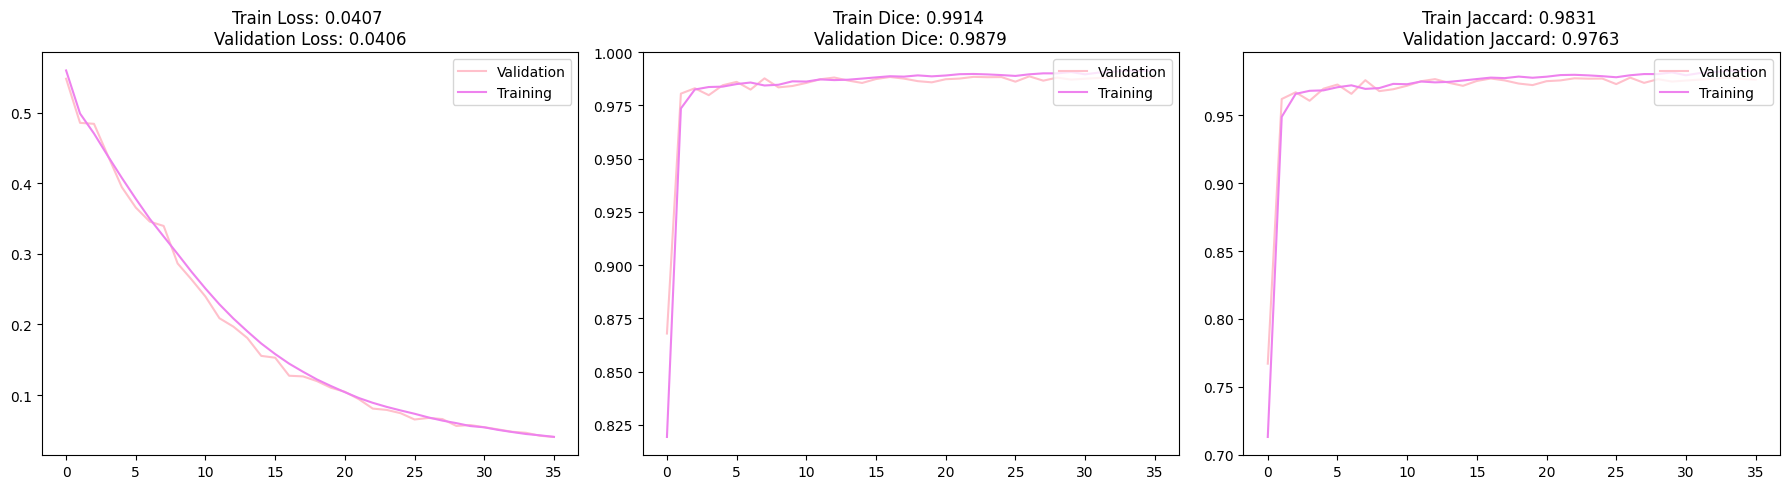

train epoch 37/60: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.0395 | Dice: 0.9908 | IoU: 0.9819


val epoch 37/60: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Loss: 0.0413 | Dice: 0.9865 | IoU: 0.9736


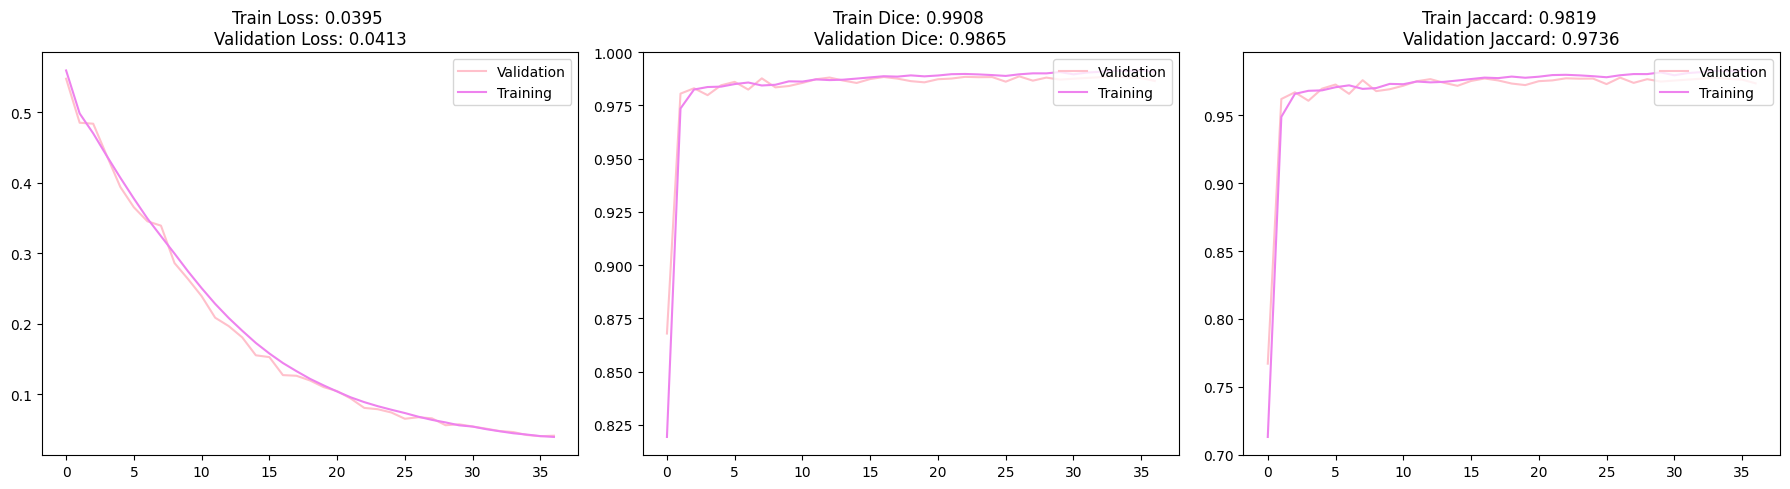

train epoch 38/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0378 | Dice: 0.9910 | IoU: 0.9822


val epoch 38/60: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Loss: 0.0408 | Dice: 0.9876 | IoU: 0.9758


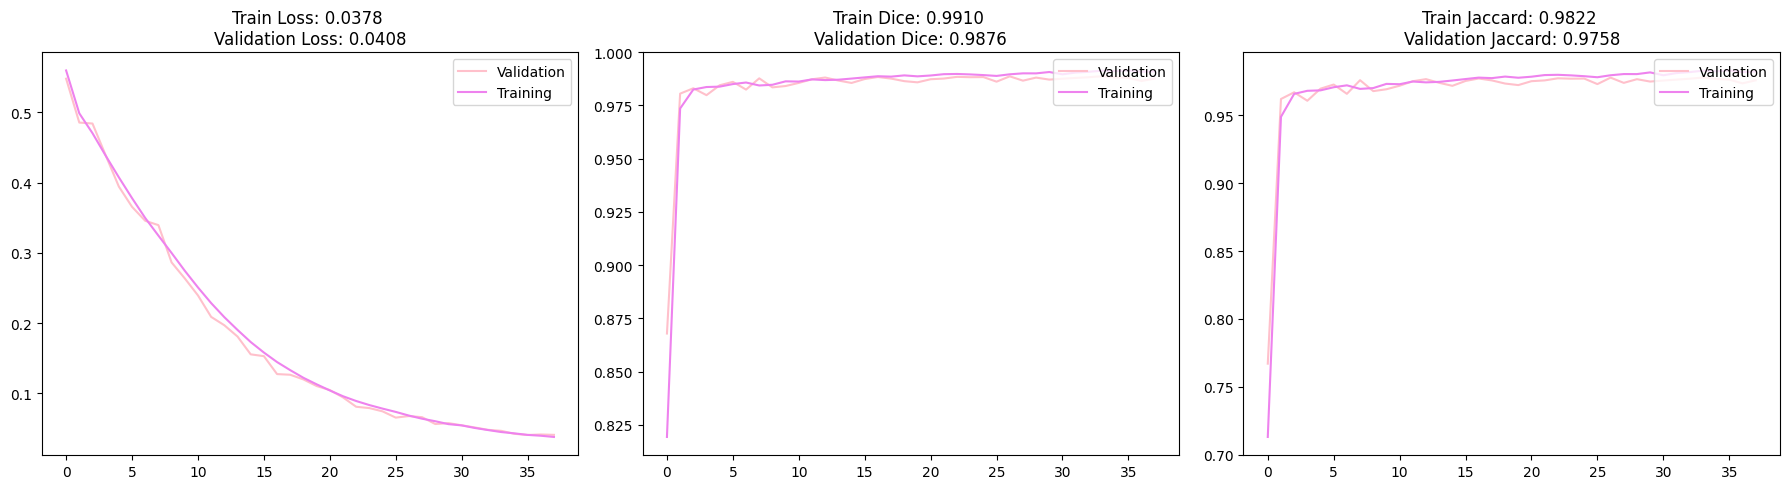

train epoch 39/60: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.0358 | Dice: 0.9915 | IoU: 0.9831


val epoch 39/60: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Loss: 0.0389 | Dice: 0.9876 | IoU: 0.9758


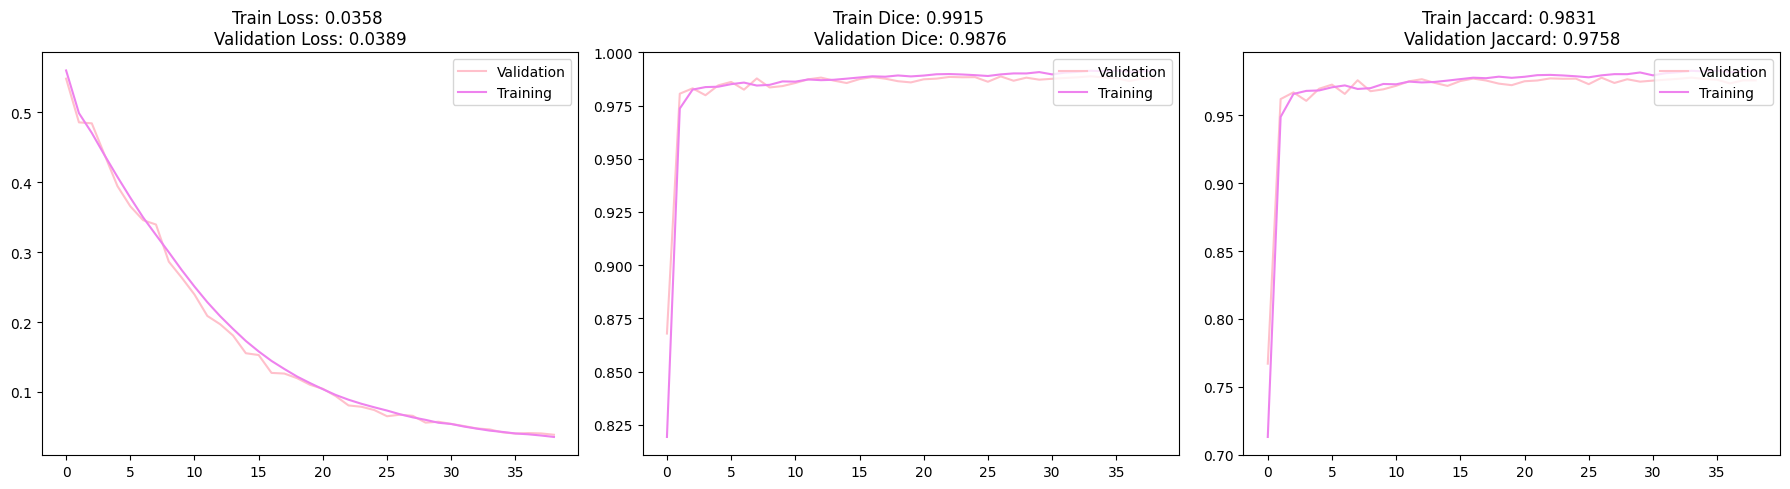

train epoch 40/60: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.0352 | Dice: 0.9906 | IoU: 0.9815


val epoch 40/60: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Loss: 0.0375 | Dice: 0.9878 | IoU: 0.9761


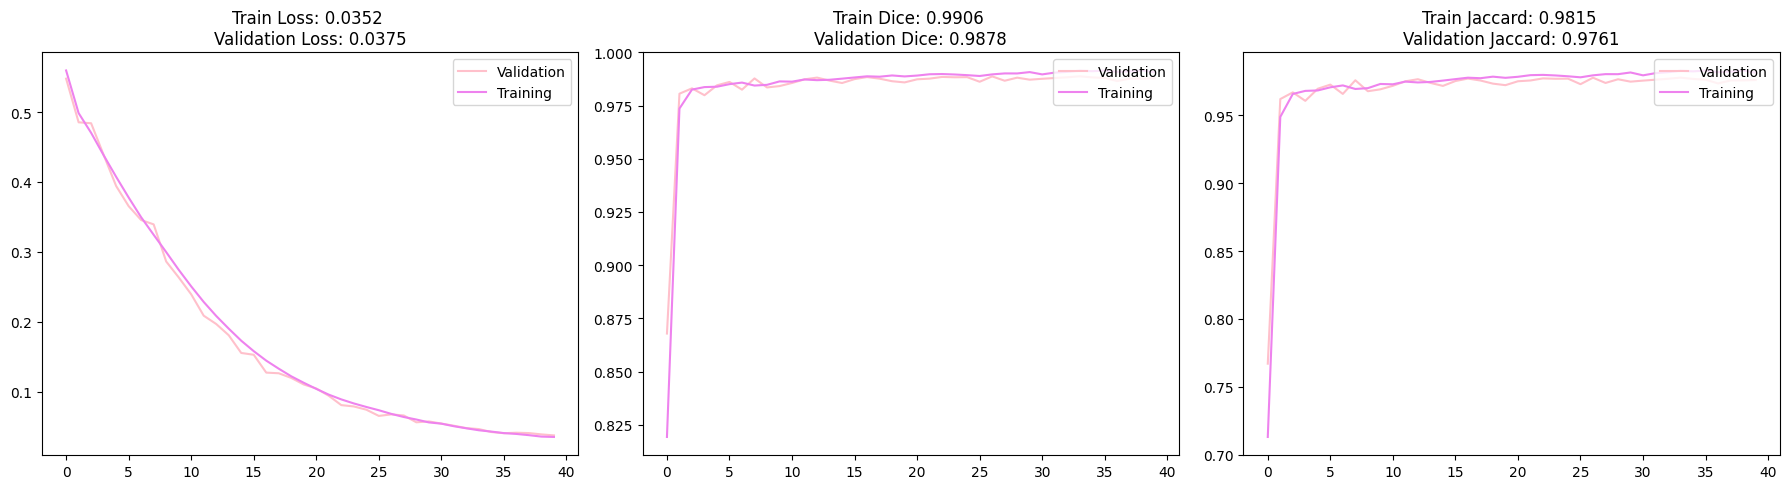

train epoch 41/60: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.0329 | Dice: 0.9917 | IoU: 0.9836


val epoch 41/60: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Loss: 0.0364 | Dice: 0.9880 | IoU: 0.9764


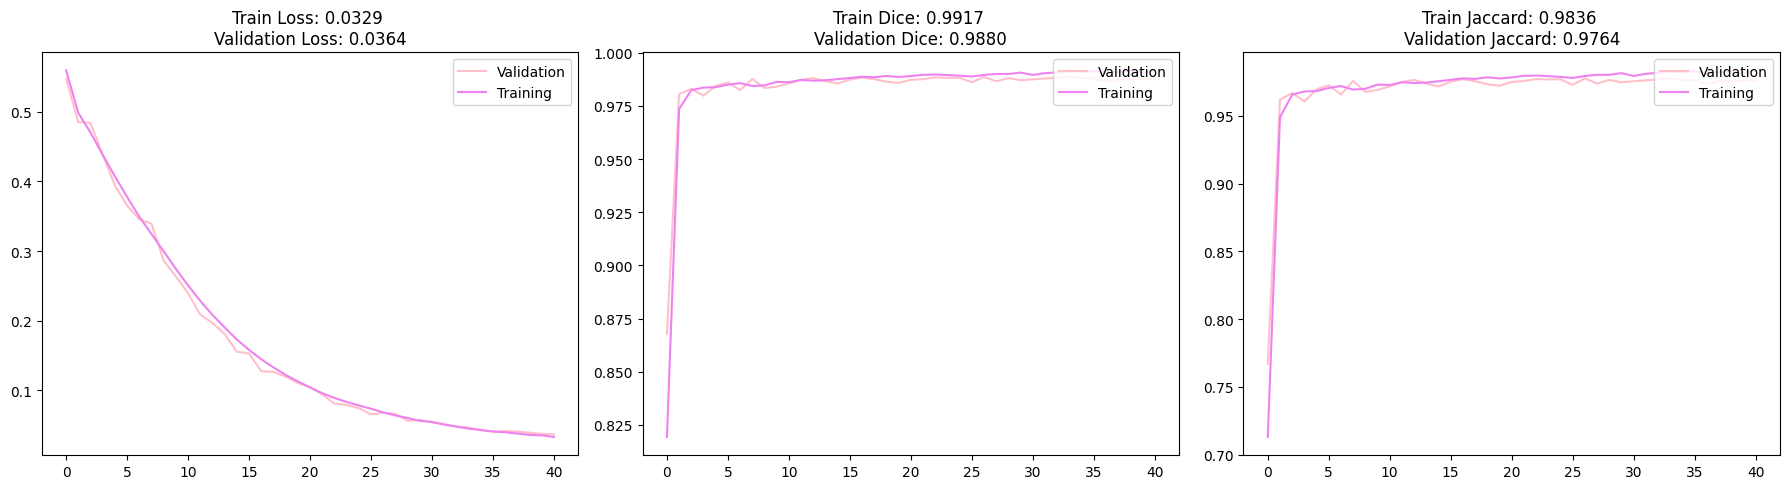

train epoch 42/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0323 | Dice: 0.9912 | IoU: 0.9826


val epoch 42/60: 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Loss: 0.0336 | Dice: 0.9890 | IoU: 0.9785


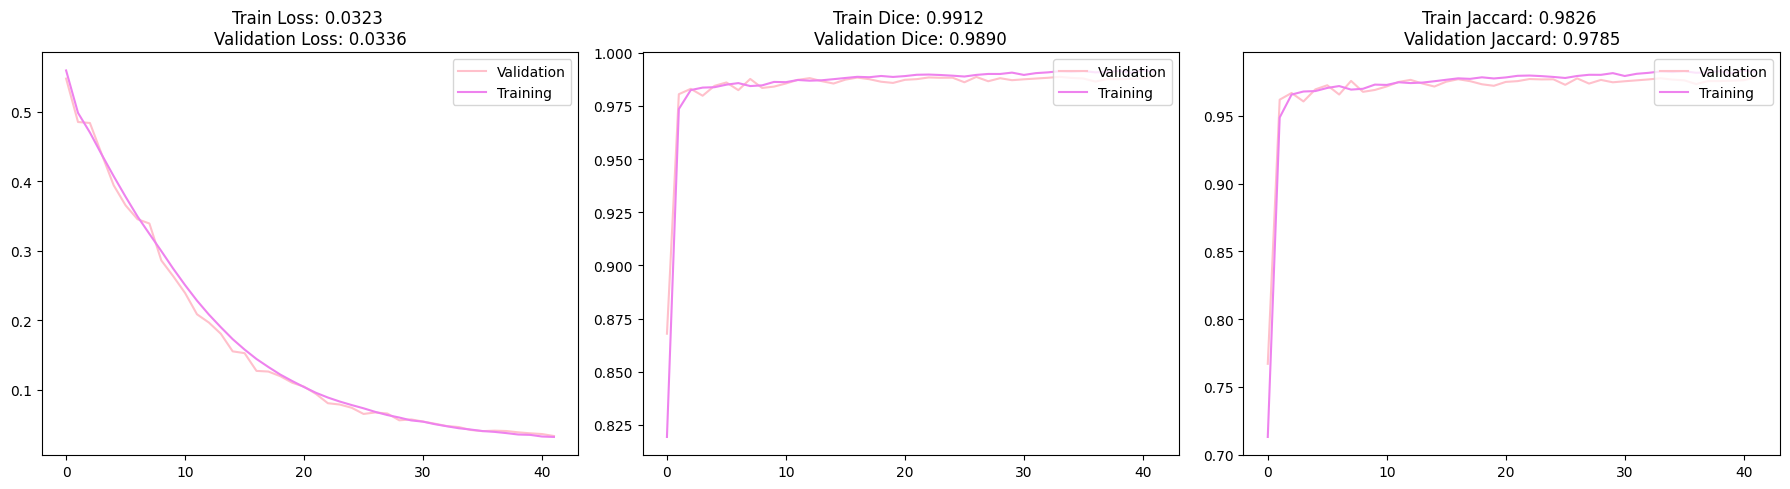

train epoch 43/60: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.0306 | Dice: 0.9917 | IoU: 0.9835


val epoch 43/60: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Loss: 0.0327 | Dice: 0.9890 | IoU: 0.9784


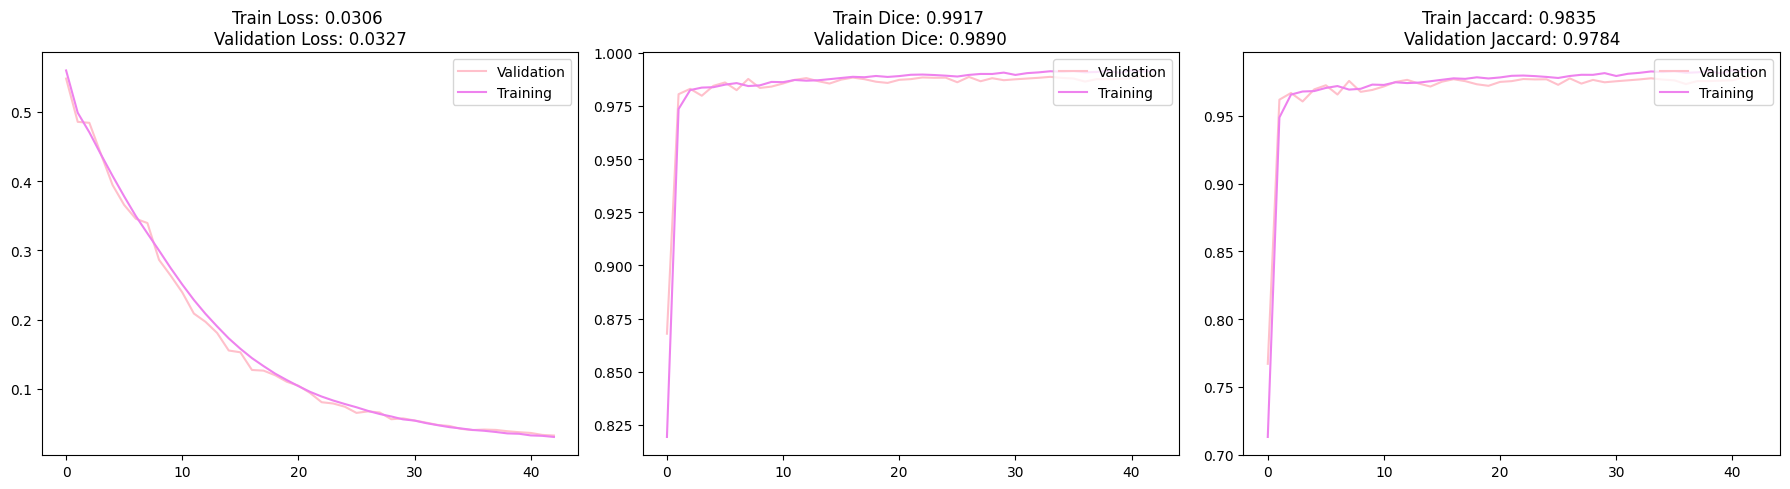

train epoch 44/60: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.0293 | Dice: 0.9920 | IoU: 0.9841


val epoch 44/60: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


Loss: 0.0342 | Dice: 0.9869 | IoU: 0.9742


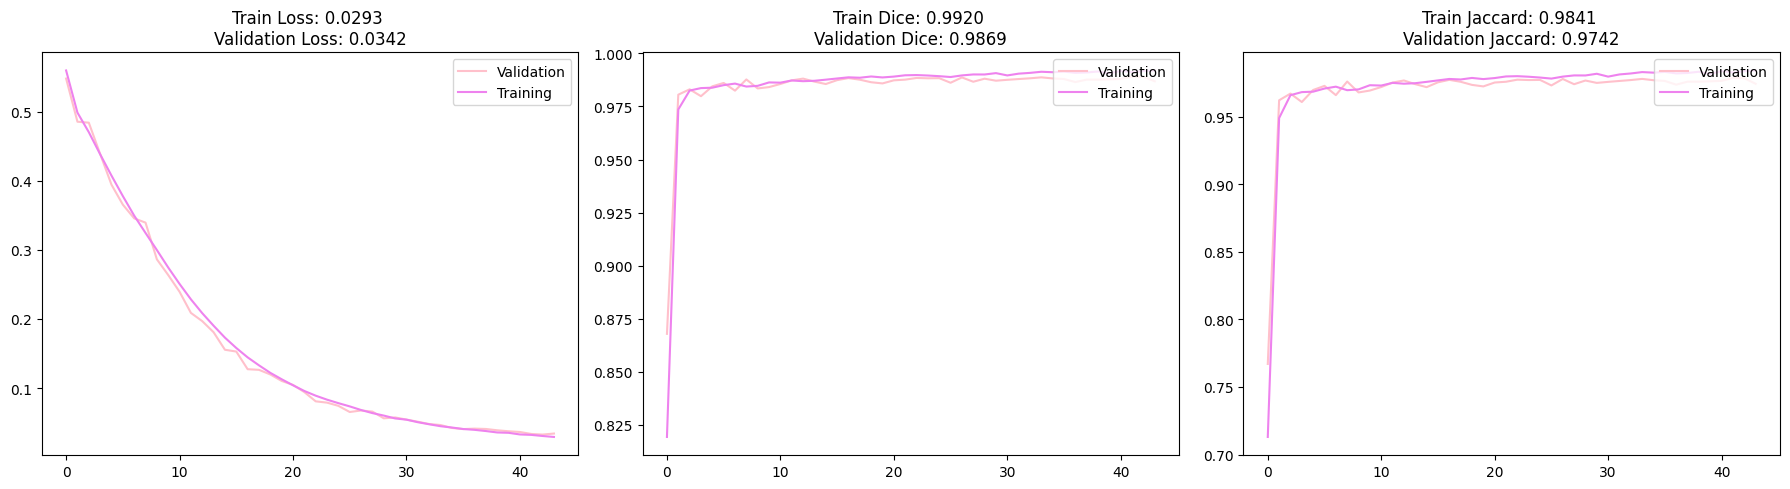

train epoch 45/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0285 | Dice: 0.9918 | IoU: 0.9837


val epoch 45/60: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Loss: 0.0338 | Dice: 0.9869 | IoU: 0.9745


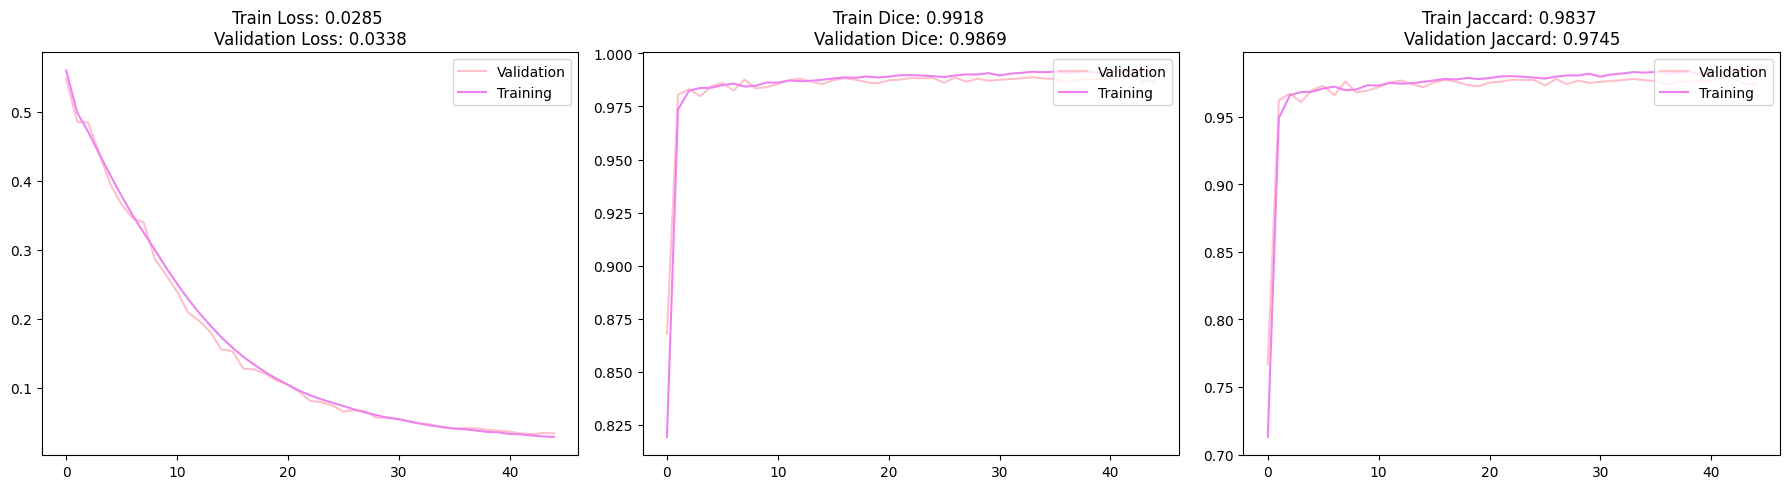

train epoch 46/60: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Loss: 0.0272 | Dice: 0.9921 | IoU: 0.9844


val epoch 46/60: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Loss: 0.0303 | Dice: 0.9883 | IoU: 0.9771


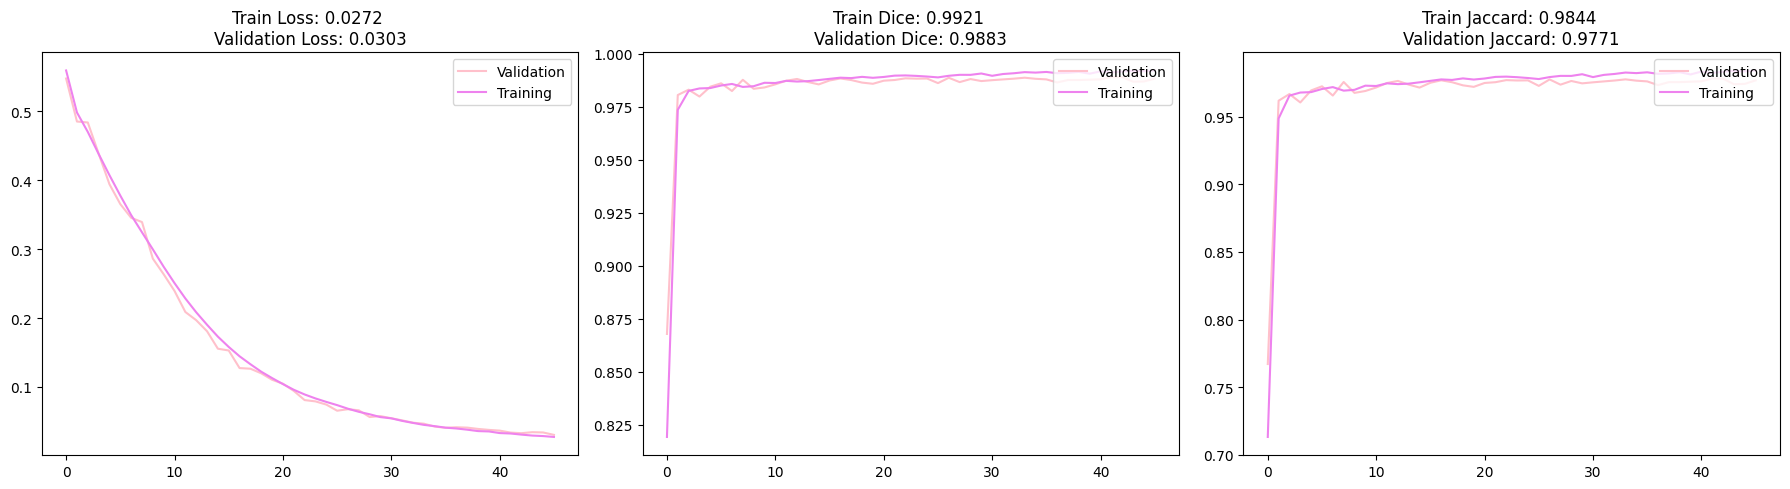

train epoch 47/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0267 | Dice: 0.9919 | IoU: 0.9839


val epoch 47/60: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Loss: 0.0294 | Dice: 0.9887 | IoU: 0.9778


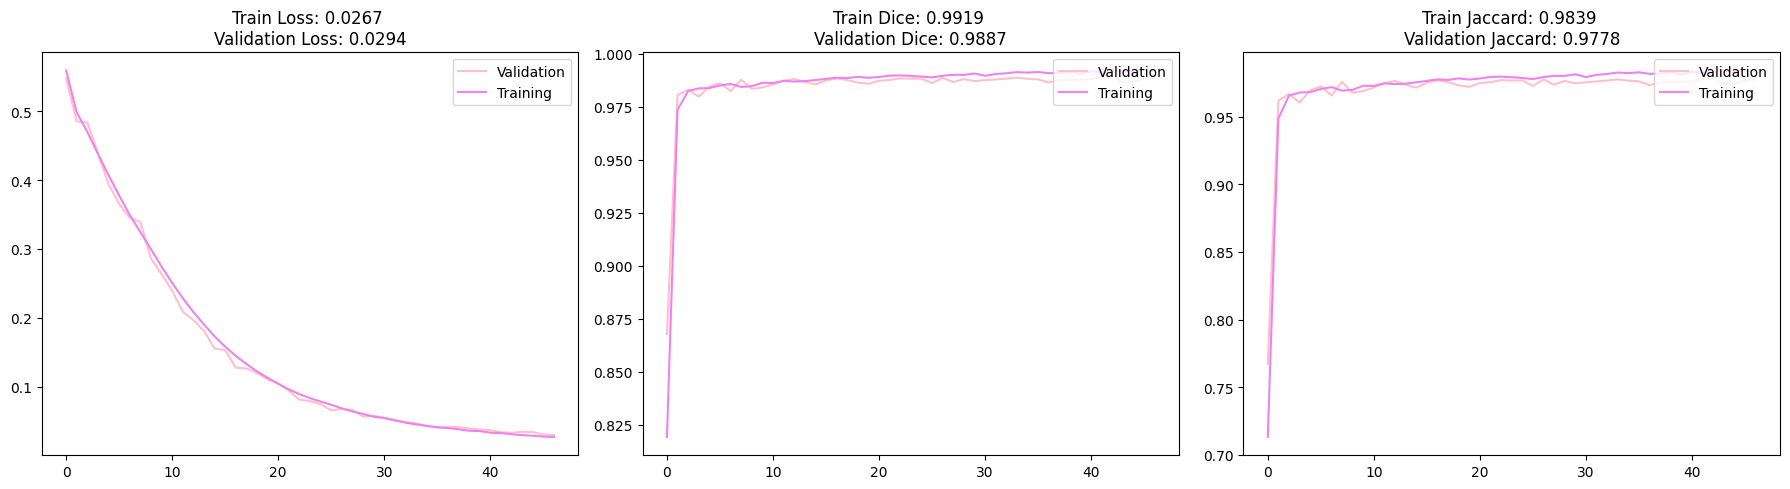

train epoch 48/60: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.0252 | Dice: 0.9925 | IoU: 0.9851


val epoch 48/60: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Loss: 0.0279 | Dice: 0.9889 | IoU: 0.9782


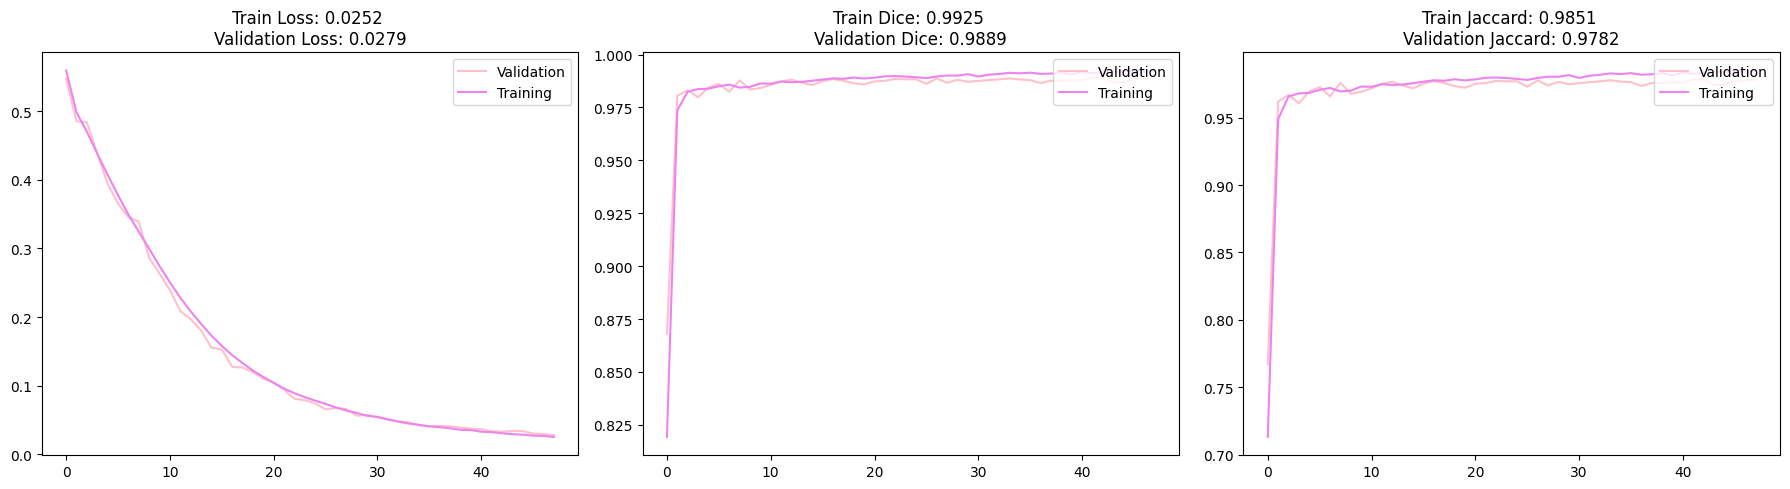

train epoch 49/60: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.0245 | Dice: 0.9925 | IoU: 0.9851


val epoch 49/60: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Loss: 0.0289 | Dice: 0.9881 | IoU: 0.9767


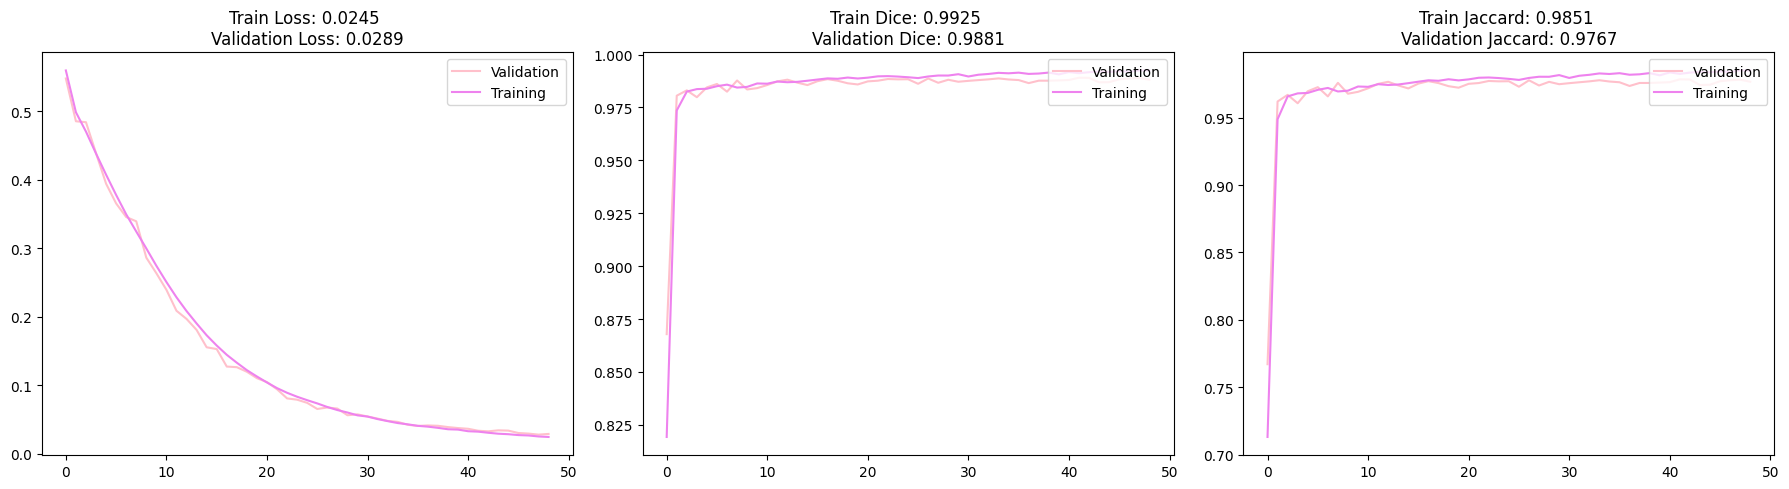

train epoch 50/60: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.0238 | Dice: 0.9924 | IoU: 0.9850


val epoch 50/60: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Loss: 0.0290 | Dice: 0.9881 | IoU: 0.9768


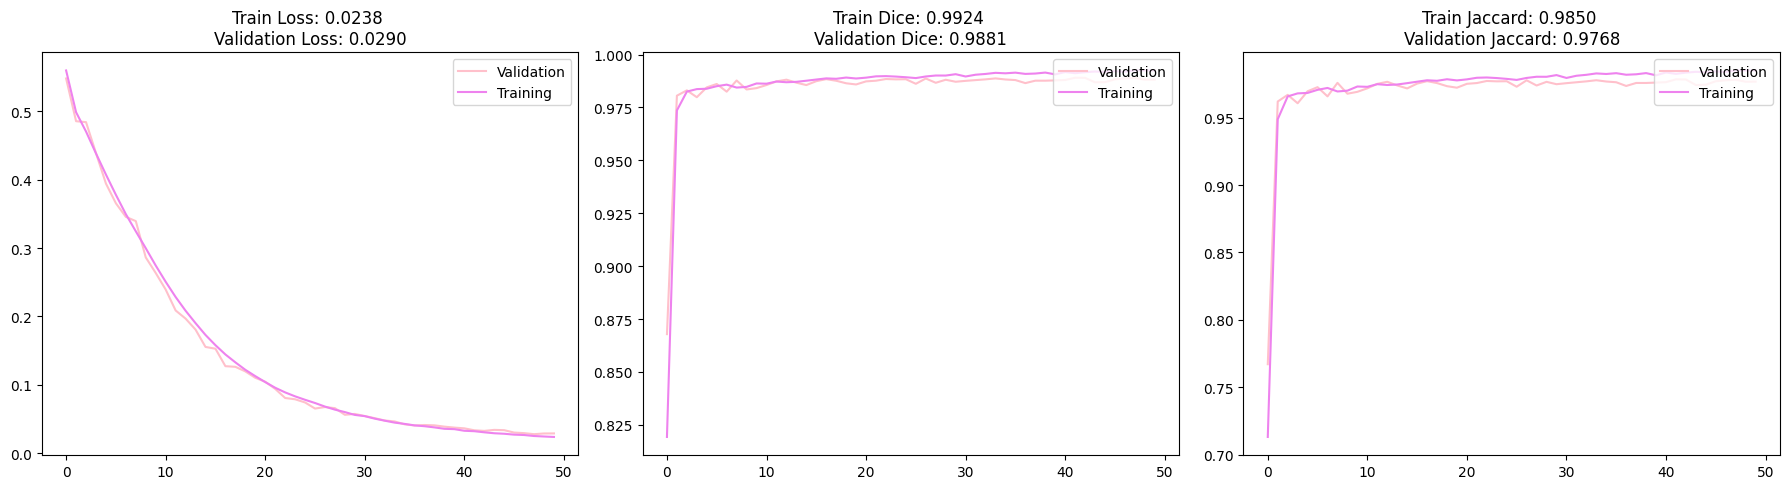

train epoch 51/60: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.0231 | Dice: 0.9925 | IoU: 0.9851


val epoch 51/60: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Loss: 0.0278 | Dice: 0.9881 | IoU: 0.9768


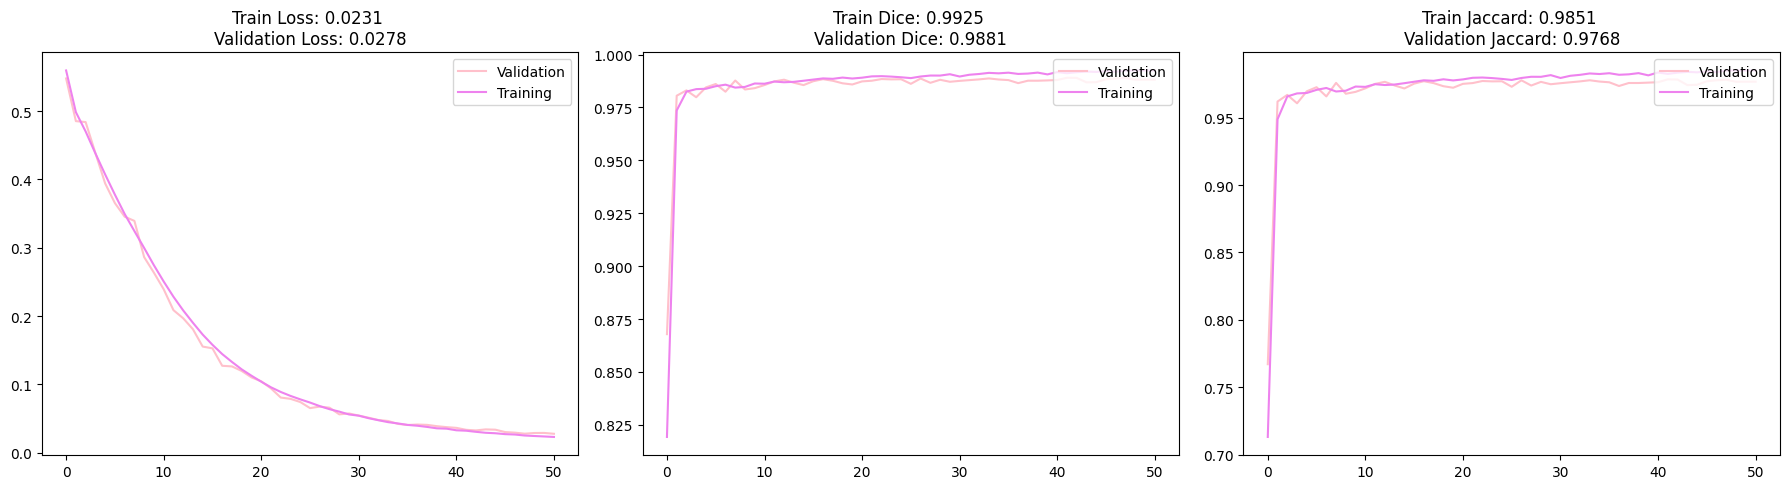

train epoch 52/60: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.0223 | Dice: 0.9927 | IoU: 0.9855


val epoch 52/60: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Loss: 0.0258 | Dice: 0.9882 | IoU: 0.9769


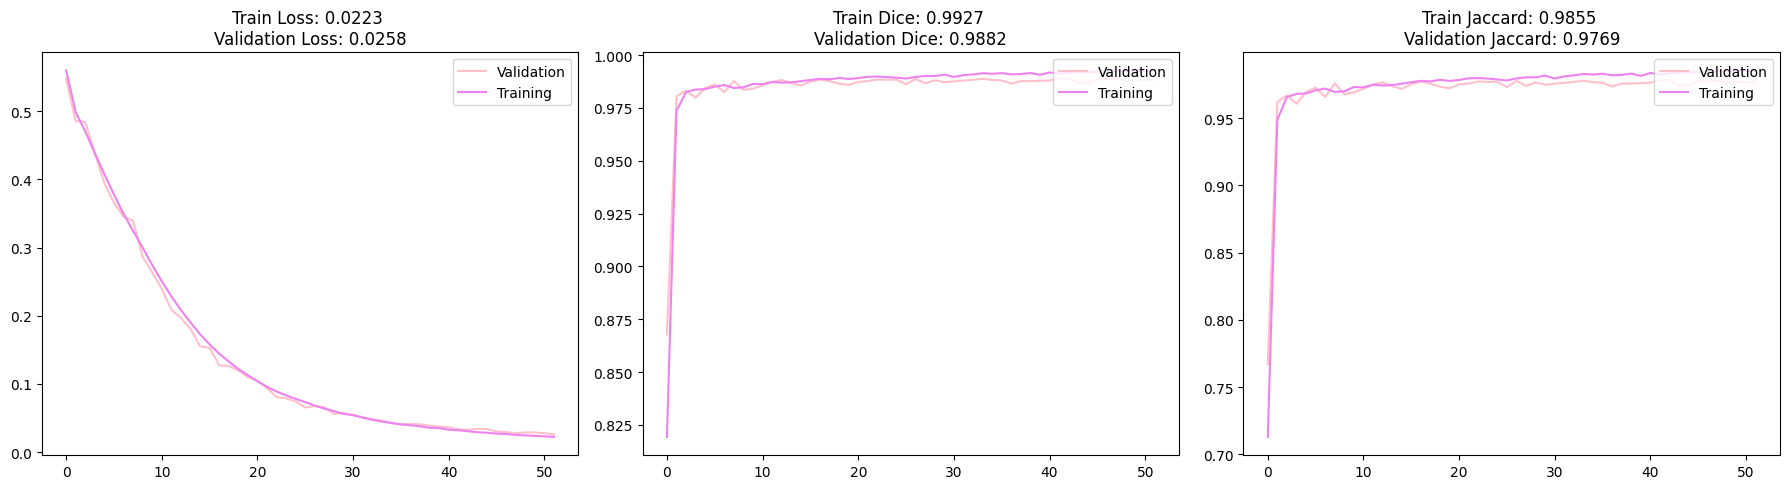

train epoch 53/60:  88%|████████▊ | 35/40 [00:27<00:03,  1.30it/s]

In [ ]:
%%time
trainer.run()

In [ ]:
## Evaluacija modela po klasama, računajući Dice i Jaccard koeficijente za svaku klasu

def compute_scores_per_classes(model, dataloader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()


            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [ ]:
model.eval();

In [ ]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, valid_dl, ['WT', 'TC', 'ET', 'BG'])

In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
val_metics_df.sample(5)

In [ ]:
## Prosječne vrijednosti Dice i Jaccard koeficijenata za svaku od klasa na validacijskom skupu

unique_categories = val_metics_df.mean().index
palette = sns.color_palette("husl", len(unique_categories))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), hue=val_metics_df.mean().index, palette=palette, ax=ax, legend=False)

ax.set_xticks(range(len(val_metics_df.mean().index)))
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)

ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')

plt.show()

In [ ]:
def show_results(model, test_dl):
    dl_iter = iter(test_dl)
    images, masks = next(dl_iter)

    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images.float())

    preds = torch.argmax(outputs, dim=1)
    masks = torch.argmax(masks, dim=1)
    masks = masks * 84
    preds = preds * 84

    plt.figure(figsize=(25, 65))

    for i in range(3):
        for j in range(len(modality_types)):
            plt.subplot(16, 6, 6 * i + j + 1)
            plt.axis('off')
            plt.title(modality_types[j])
            plt.imshow(images[i][j].cpu(), cmap='gray')

        # show True Mask
        plt.subplot(16, 6, 6 * i + 5)
        plt.title('True Mask')
        plt.grid()
        plt.imshow(255 - masks[i].cpu(), cmap='viridis')

        # show Predicted Mask
        plt.subplot(16, 6, 6 * i + 6)
        plt.title('Predicted Mask')
        plt.grid()
        plt.imshow(255 - preds[i].cpu(), cmap='viridis')

    plt.show()

show_results(model, valid_dl)

In [ ]:
def visualize_predictions(dataset, model, modality_types, num_samples):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Extract patient ID
        patient_id = os.path.basename(dataset.img_dirs[i])

        # Create a single figure with three rows
        plt.figure(figsize=(15, 8))

        # Visualize the MRI modalities in the first row
        for j in range(len(modality_types)):
            plt.subplot(3, len(modality_types), j + 1)
            plt.imshow(image[j], cmap='gray')
            plt.axis('off')
            plt.title(f"{modality_types[j]}")

        # Forward pass to get predictions
        with torch.no_grad():
            model_input = torch.tensor(image).unsqueeze(0).to(device).float()
            prediction = model(model_input).squeeze().cpu().numpy()

        # Visualize channels 1 and 3 of the predicted segmentation mask in the second row
        plt.subplot(3, len(modality_types), len(modality_types) + 1)
        plt.imshow(prediction[1], cmap='viridis')
        plt.grid()
        plt.title("Predicted Mask Channel 1")

        plt.subplot(3, len(modality_types), len(modality_types) + 2)
        plt.imshow(mask[1], cmap='viridis')
        plt.grid()
        plt.title("Original Mask Channel 1")

        plt.suptitle(f"Sample {i} - Patient ID: {patient_id}")
        plt.show()

visualize_predictions(train_ds, model, modality_types, num_samples=3)